# Import packages & functions

In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator

# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
import sgm
from pkgs.MindEyeV2.src.generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder # bigG embedder

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import pkgs.MindEyeV2.src.utils as utils

import lovely_tensors as lt
lt.monkey_patch()

from csng.data import get_dataloaders
from csng.utils.mix import seed_all
from csng.utils.data import crop

DATA_PATH_BRAINREADER = os.path.join(os.environ["DATA_PATH"], "brainreader")
DATA_PATH_CAT_V1 = os.path.join(os.environ["DATA_PATH"], "cat_V1_spiking_model", "50K_single_trial_dataset")
DATA_PATH_MOUSE_V1 = os.path.join(os.environ["DATA_PATH"], "mouse_v1_sensorium22")
DATA_PATH_MINDEYE = os.path.join(os.environ["DATA_PATH"], "mindeye")
DATA_PATH_MINDEYE_CACHE = os.path.join(DATA_PATH_MINDEYE, "cache")
print(f"{DATA_PATH_BRAINREADER=}\n{DATA_PATH_MINDEYE=}\n{DATA_PATH_MINDEYE_CACHE=}")

!nvidia-smi

/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


DATA_PATH_BRAINREADER='/scratch/izar/sobotka/csng/brainreader'
DATA_PATH_MINDEYE='/scratch/izar/sobotka/csng/mindeye'
DATA_PATH_MINDEYE_CACHE='/scratch/izar/sobotka/csng/mindeye/cache'
Thu Apr  3 16:07:13 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:86:00.0 Off |                  Off |
| N/A   37C    P0              26W / 250W |      0MiB / 32768Mi

# Configurations

In [2]:
cfg = {
    "device": "cuda",
    "data_type": torch.float32,
    "seed": 0,
    "data": {"mixing_strategy": "parallel_min", "max_training_batches": None},
    "wandb": {"project": os.environ["WANDB_PROJECT"], "group": "mindeye"},
    "data_name": "mouse_v1",
    "crop_wins": {
        "mouse_v1": (22, 36),
        "cat_v1": (20, 20),
        "brainreader_mouse": None,
    },
}

### setup data config
# cfg["data"][cfg["data_name"]] = {
#     "device": cfg["device"],
#     "mixing_strategy": cfg["data"]["mixing_strategy"],
#     "max_batches": None,
#     "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
#     "batch_size": 1,
#     # "sessions": (subj_list := list(range(1, 23))),
#     "sessions": (subj_list := [1,2,3,4,5,6,7,8]),
#     "resize_stim_to": (36, 64),
#     "normalize_stim": True,
#     "normalize_resp": True,
#     "div_resp_by_std": True,
#     "clamp_neg_resp": False,
#     "additional_keys": None,
#     "avg_test_resp": True,
#     "drop_last": False,
# }

cfg["data"]["mouse_v1"] = {
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
            os.path.join(DATA_PATH_MOUSE_V1, "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-1
            # os.path.join(DATA_PATH_MOUSE_V1, "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-2
            # os.path.join(DATA_PATH_MOUSE_V1, "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-3
            # os.path.join(DATA_PATH_MOUSE_V1, "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-4
            # os.path.join(DATA_PATH_MOUSE_V1, "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-5
        ],
        "normalize": True,
        "z_score_responses": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": False,
        # "batch_size": 2,
        "batch_size": 8,
        "drop_last": True,
        # "seed": cfg["seed"],
        "use_cache": False,
    },
    "skip_train": False,
    "skip_val": False,
    "skip_test": False,
    "normalize_neuron_coords": True,
    "average_test_multitrial": True,
    "save_test_multitrial": True,
    "test_batch_size": 7,
    "device": cfg["device"],
}
cfg["data"]["mouse_v1"]["batch_size"] = cfg["data"]["mouse_v1"]["dataset_config"]["batch_size"]
subj_list = [
    '-'.join(path.split("/")[-1].replace("static", "").split("-")[:3])
    for path in cfg["data"]["mouse_v1"]["dataset_config"]["paths"]
]
print(f"{subj_list=}")

# cfg["data"]["cat_v1"] = {
#     "dataset_config": {
#         "train_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "train"),
#         "val_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "val"),
#         "test_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "test"),
#         "image_size": [50, 50],
#         "crop": False,
#         "batch_size": 8,
#         "stim_keys": ("stim",),
#         "resp_keys": ("exc_resp", "inh_resp"),
#         "return_coords": True,
#         "return_ori": False,
#         "coords_ori_filepath": os.path.join(DATA_PATH_CAT_V1, "pos_and_ori.pkl"),
#         "cached": False,
#         "stim_normalize_mean": 46.143,
#         "stim_normalize_std": 24.960,
#         "resp_normalize_mean": torch.load(
#             os.path.join(DATA_PATH_CAT_V1, "responses_mean.pt")
#         ),
#         "resp_normalize_std": torch.load(
#             os.path.join(DATA_PATH_CAT_V1, "responses_std.pt")
#         ),
#         "clamp_neg_resp": False,
#     },
# }
# cfg["data"]["cat_v1"]["batch_size"] = cfg["data"]["cat_v1"]["dataset_config"]["batch_size"]
# subj_list = ["cat_v1"]
# print(f"{subj_list=}")


### setup model config
cfg["model"] = {
    "model_name": (model_name := "csng_mouse_v1__03-04-25_16-06"),
    "cache_dir": DATA_PATH_MINDEYE_CACHE,
    "outdir": f'{DATA_PATH_MINDEYE}/train_logs/{model_name}',
    "evalsdir": f'{DATA_PATH_MINDEYE}/evals/{model_name}',
    "ckpt_saving": True,
    "ckpt_interval": 1,

    # "subj_list": [6], # list(range(1, 23))
    # "num_voxels_list": [8587],
    # "num_voxels": {
    #     f'subj06': 8587,
    # },

    "subj_list": subj_list,
    # "num_voxels_list": (num_voxels_list := [dset.n_neurons for dset in get_dataloaders(config=cfg)[0]["train"][cfg["data_name"]].datasets]),
    "num_voxels_list": (num_voxels_list := [next(iter(dl))[1].shape[-1] for dl in get_dataloaders(config=cfg)[0]["train"][cfg["data_name"]].dataloaders]),
    "num_voxels": {
        (f"subj{subj:02d}" if subj.isnumeric() else f"subj{subj}"): num_voxels
        for subj, num_voxels in zip(subj_list, num_voxels_list)
    },
    "hidden_dim": 768,
    "n_blocks": 4,
    "clip_scale": 1.,
    "use_prior": True,
    "prior_scale": 30,
    "num_epochs": 100,
    "num_iterations_per_epoch": 500,
    # "mixup_pct": 0.33,
    "mixup_pct": 0.,
    "blurry_recon": True,
    "blur_scale": 0.54,
    "use_image_aug": False,
}

subj_list=['21067-10-18']


In [3]:
### create dirs
os.makedirs(cfg["model"]["outdir"], exist_ok=True)
os.makedirs(cfg["model"]["cache_dir"], exist_ok=True)
print(cfg["model"]["outdir"])

/scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06


# Prep data, models, and dataloaders

In [4]:
seed_all(cfg["seed"])
dls, _ = get_dataloaders(config=cfg)
train_dl, val_dl = dls["train"][cfg["data_name"]], dls["val"][cfg["data_name"]]
train_dls = {subj_name: dl for subj_name, dl in zip(cfg["model"]["num_voxels"].keys(), train_dl.dataloaders)}
display(train_dls)

print("dividing batch size by subj_list, which will then be concatenated across subj during training...") 
cfg["model"]["num_samples_per_epoch"] = sum(len(dl) * dl.batch_size for dl in train_dls.values())
cfg["model"]["num_iterations_per_epoch"] = cfg["model"]["num_samples_per_epoch"] // (cfg["data"][cfg["data_name"]]["batch_size"] * len(cfg["model"]["subj_list"]))

{'subj21067-10-18': <torch.utils.data.dataloader.DataLoader at 0x7f3712cd5f50>}

dividing batch size by subj_list, which will then be concatenated across subj during training...


## Load models

### CLIP image embeddings  model

In [5]:
cfg["model"]["clip_img_embedder_arch"] = "ViT-bigG-14"
cfg["model"]["clip_img_embedder_version"] = "laion2b_s39b_b160k"
cfg["model"]["clip_seq_dim"] = 256
cfg["model"]["clip_emb_dim"] = 1664

clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch=cfg["model"]["clip_img_embedder_arch"],
    version=cfg["model"]["clip_img_embedder_version"],
    output_tokens=True,
    only_tokens=True,
    cache_dir=cfg["model"]["cache_dir"],
)
clip_img_embedder.to(cfg["device"])

FrozenOpenCLIPImageEmbedder(
  (model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 1664, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-47): 48 x ResidualAttentionBlock(
            (ln_1): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1664, out_features=1664, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1664, out_features=8192, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=8192, out_features=1664, bias=True)
            )
            (ls_2): Identity()


### SD VAE

In [6]:
if cfg["model"]["blurry_recon"]:
    ### SD VAE
    from diffusers import AutoencoderKL
    cfg["model"]["autoenc"] = {
        "down_block_types": ['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D'],
        "up_block_types": ['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D'],
        "block_out_channels": [128, 256, 512, 512],
        "layers_per_block": 2,
        "sample_size": 256,
    }
    autoenc = AutoencoderKL(**cfg["model"]["autoenc"])
    autoenc.load_state_dict(torch.load(f'{cfg["model"]["cache_dir"]}/sd_image_var_autoenc.pth'))
    autoenc.eval()
    autoenc.requires_grad_(False)
    autoenc.to(cfg["device"])
    utils.count_params(autoenc)

    ### VICRegL ConvNext-XL
    from pkgs.MindEyeV2.src.autoencoder.convnext import ConvnextXL
    cnx = ConvnextXL(f'{cfg["model"]["cache_dir"]}/convnext_xlarge_alpha0.75_fullckpt.pth')
    cnx.requires_grad_(False)
    cnx.eval()
    cnx.to(cfg["device"])
    utils.count_params(cnx)

    import kornia
    from kornia.augmentation.container import AugmentationSequential
    mean = torch.tensor([0.485, 0.456, 0.406]).to(cfg["device"]).reshape(1,3,1,1)
    std = torch.tensor([0.228, 0.224, 0.225]).to(cfg["device"]).reshape(1,3,1,1)
    blur_augs = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1, p=0.8),
        kornia.augmentation.RandomGrayscale(p=0.1),
        kornia.augmentation.RandomSolarize(p=0.1),
        kornia.augmentation.RandomResizedCrop((224,224), scale=(.9,.9), ratio=(1,1), p=1.0),
        data_keys=["input"],
    )

param counts:
83,653,863 total
0 trainable
param counts:
349,687,808 total
0 trainable


### MindEye modules

In [7]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    
    def forward(self, x):
        return x

class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer to enable regularization
    def __init__(self, input_sizes, out_features): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
            torch.nn.Linear(input_size, out_features) for input_size in input_sizes
        ])
    
    def forward(self, x, subj_idx):
        out = self.linears[subj_idx](x[:,0]).unsqueeze(1)
        return out

In [8]:
### init model
model = MindEyeModule()
model.ridge = RidgeRegression(cfg["model"]["num_voxels_list"], out_features=cfg["model"]["hidden_dim"])
utils.count_params(model.ridge)
utils.count_params(model)

# test on subject 1 with fake data
b = torch.randn((2,1,cfg["model"]["num_voxels_list"][0]))
print(b.shape, model.ridge(b,0).shape)

param counts:
6,430,464 total
6,430,464 trainable
param counts:
6,430,464 total
6,430,464 trainable
torch.Size([2, 1, 8372]) torch.Size([2, 1, 768])


In [9]:
from pkgs.MindEyeV2.src.models import BrainNetwork

### backbone
cfg["model"]["brainnetwork"] = {
    "h": cfg["model"]["hidden_dim"],
    "in_dim": cfg["model"]["hidden_dim"],
    "seq_len": 1,
    "n_blocks": cfg["model"]["n_blocks"],
    "clip_size": cfg["model"]["clip_emb_dim"],
    "out_dim": cfg["model"]["clip_emb_dim"] * cfg["model"]["clip_seq_dim"],
    "blurry_recon": cfg["model"]["blurry_recon"],
    "clip_scale": cfg["model"]["clip_scale"],
}
model.backbone = BrainNetwork(**cfg["model"]["brainnetwork"])
utils.count_params(model.backbone)
utils.count_params(model)

# test that the model works on some fake data
b = torch.randn((2,1,cfg["model"]["hidden_dim"]))
print("b.shape",b.shape)

backbone_, clip_, blur_ = model.backbone(b)
print(backbone_.shape, clip_.shape, blur_[0].shape, blur_[1].shape)

param counts:
345,356,284 total
345,356,284 trainable
param counts:
351,786,748 total
351,786,748 trainable
b.shape torch.Size([2, 1, 768])
torch.Size([2, 256, 1664]) torch.Size([2, 256, 1664]) torch.Size([2, 4, 28, 28]) torch.Size([2, 49, 512])


### Adding diffusion prior + unCLIP if use_prior=True

In [10]:
if cfg["model"]["use_prior"]:
    from pkgs.MindEyeV2.src.models import *

    ### setup diffusion prior network
    cfg["model"]["out_dim"] = cfg["model"]["clip_emb_dim"]
    cfg["model"]["depth"] = 5
    cfg["model"]["dim_head"] = 52
    cfg["model"]["heads"] = cfg["model"]["clip_emb_dim"] // cfg["model"]["dim_head"]
    cfg["model"]["timesteps"] = 100
    cfg["model"]["prior_network"] = {
        "dim": cfg["model"]["out_dim"],
        "depth": cfg["model"]["depth"],
        "dim_head": cfg["model"]["dim_head"],
        "heads": cfg["model"]["heads"],
        "causal": False,
        "num_tokens": cfg["model"]["clip_seq_dim"],
        "learned_query_mode": "pos_emb",
        "normformer": True,
    }
    cfg["model"]["brain_diffusion_prior"] = {
        "image_embed_dim": cfg["model"]["out_dim"],
        "condition_on_text_encodings": False,
        "timesteps": cfg["model"]["timesteps"],
        "cond_drop_prob": 0.2,
        "image_embed_scale": None,
    }

    prior_network = PriorNetwork(**cfg["model"]["prior_network"])
    model.diffusion_prior = BrainDiffusionPrior(net=prior_network, **cfg["model"]["brain_diffusion_prior"])
    utils.count_params(model.diffusion_prior)
    utils.count_params(model)

param counts:
220,955,800 total
220,955,784 trainable
param counts:
572,742,548 total
572,742,532 trainable


### Setup optimizer / lr / ckpt saving

In [11]:
cfg["model"]["optimization"] = {
    "no_decay": ['bias', 'LayerNorm.bias', 'LayerNorm.weight'],
    "max_lr": 3e-4,
    "lr_scheduler_type": 'cycle',
}

opt_grouped_parameters = [
    {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in cfg["model"]["optimization"]["no_decay"])], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in cfg["model"]["optimization"]["no_decay"])], 'weight_decay': 0.0},
]
if cfg["model"]["use_prior"]:
    opt_grouped_parameters.extend([
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if not any(nd in n for nd in cfg["model"]["optimization"]["no_decay"])], 'weight_decay': 1e-2},
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if any(nd in n for nd in cfg["model"]["optimization"]["no_decay"])], 'weight_decay': 0.0}
    ])

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=cfg["model"]["optimization"]["max_lr"])

if cfg["model"]["optimization"]["lr_scheduler_type"] == 'linear':
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=cfg["model"]["num_epochs"]*cfg["model"]["num_iterations_per_epoch"],
        last_epoch=-1
    )
elif cfg["model"]["optimization"]["lr_scheduler_type"] == 'cycle':
    cfg["model"]["optimization"]["total_steps"] = int(np.floor(cfg["model"]["num_epochs"]*cfg["model"]["num_iterations_per_epoch"]))
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=cfg["model"]["optimization"]["max_lr"],
        total_steps=cfg["model"]["optimization"]["total_steps"],
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/cfg["model"]["num_epochs"],
    )
    print("total_steps", cfg["model"]["optimization"]["total_steps"])

def save_ckpt(tag):
    ckpt_path = cfg["model"]["outdir"]+f'/{tag}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'train_losses': losses,
        'test_losses': test_losses,
        'lrs': lrs,
        "cfg": cfg,
        "best": best,
    }, ckpt_path)
    print(f"\n---saved {cfg['model']['outdir']}/{tag} ckpt!---\n")

def load_ckpt(tag):
    ckpt_path = cfg["model"]["outdir"]+f'/{tag}.pth'
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    epoch = checkpoint['epoch']
    losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']
    lrs = checkpoint['lrs']
    best = checkpoint['best']
    optimizer.zero_grad()
    print(f"\n---loaded {cfg['model']['outdir']}/{tag} ckpt!---\n")
    return epoch, losses, test_losses, lrs, checkpoint["cfg"], best

print("\nDone with model preparations!")
num_params = utils.count_params(model)

total_steps 55900

Done with model preparations!
param counts:
572,742,548 total
572,742,532 trainable


In [12]:
model

MindEyeModule(
  (ridge): RidgeRegression(
    (linears): ModuleList(
      (0): Linear(in_features=8372, out_features=768, bias=True)
    )
  )
  (backbone): BrainNetwork(
    (mixer_blocks1): ModuleList(
      (0-3): 4 x Sequential(
        (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (1): Sequential(
          (0): Linear(in_features=768, out_features=768, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.15, inplace=False)
          (3): Linear(in_features=768, out_features=768, bias=True)
        )
      )
    )
    (mixer_blocks2): ModuleList(
      (0-3): 4 x Sequential(
        (0): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
        (1): Sequential(
          (0): Linear(in_features=1, out_features=1, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.15, inplace=False)
          (3): Linear(in_features=1, out_features=1, bias=True)
        )
      )
    )
    (backbone_linear): Linear(in_feat

In [13]:
### fine-tuning
ckpt_path = '/scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_12-08/best.pth'
checkpoint = torch.load(ckpt_path)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
optimizer.zero_grad()

In [13]:
epoch, losses, test_losses, lrs, cfg, best = load_ckpt("last")


---loaded /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---



In [14]:
model.to(cfg["device"])
optimizer.zero_grad()
epoch, losses, test_losses, lrs, cfg, best = load_ckpt("last")


---loaded /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---



# Weights and Biases

In [14]:
if cfg.get("wandb", None) is not None: # only use main process for wandb logging
    import wandb
    wandb_log = wandb.init(
        id=cfg["model"]["model_name"],
        name=cfg["model"]["model_name"],
        config=cfg,
        resume="allow",
        **cfg["wandb"],
    )
else:
    wandb_log = False

wandb: Currently logged in as: johnny1188 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


# Main

In [15]:
### img transform (1x36x64 -> 3x224x224)
img_tform = transforms.Compose([
    transforms.Lambda(lambda x: crop(x, cfg["crop_wins"][cfg["data_name"]])),
    transforms.Resize((224, 224), antialias=True),
    transforms.Lambda(lambda x: x.repeat(1, 3, 1, 1)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
if cfg["model"]["use_image_aug"]:
    img_augment = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1, p=0.3),
        same_on_batch=False,
        data_keys=["input"],
    )

  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

[E0/100 I0/559]


/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  Loss 8.177045822143555
[E0/100 I50/559]
  Loss 7.959871768951416
[E0/100 I100/559]
  Loss 12.506723403930664
[E0/100 I150/559]
  Loss 9.232945442199707
[E0/100 I200/559]
  Loss 9.154436111450195
[E0/100 I250/559]
  Loss 8.681859970092773
[E0/100 I300/559]
  Loss 6.819255828857422
[E0/100 I350/559]
  Loss 6.999658107757568
[E0/100 I400/559]
  Loss 6.465069770812988
[E0/100 I450/559]
  Loss 8.413835525512695
[E0/100 I500/559]
  Loss 5.441585540771484
[E0/100 I550/559]
  Loss 8.461433410644531

---Evaluating---


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/best ckpt!---



  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 0/100 [18:58<?, ?it/s, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b35dff50>, test/blurry_pixcorr=0.471, test/loss=9.48, test/loss_clip_total=0.271, test/loss_prior=0.307, test/num_steps=1, test/test_bwd_pct_correct=0.906, test/test_fwd_pct_correct=0.921, train/blurry_pixcorr=0.794, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=9, train/los


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 0 / 100


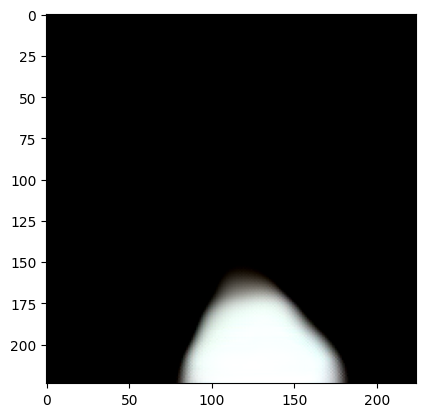

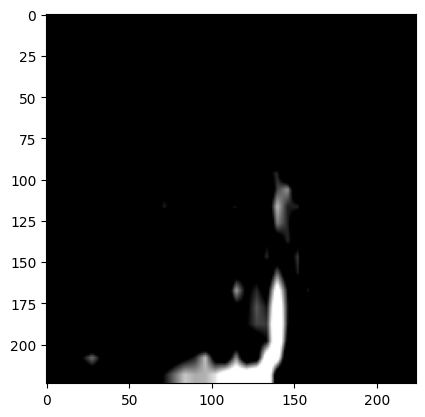

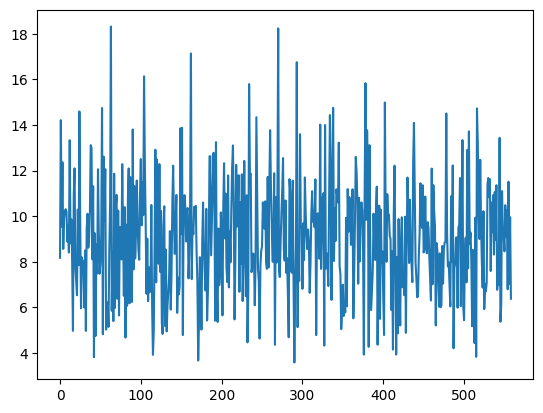

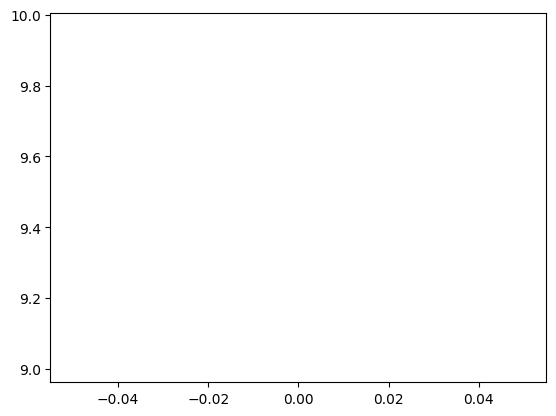

  1%|██████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 1/100 [19:07<31:33:11, 1147.39s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b35dff50>, test/blurry_pixcorr=0.471, test/loss=9.48, test/loss_clip_total=0.271, test/loss_prior=0.307, test/num_steps=1, test/test_bwd_pct_correct=0.906, test/test_fwd_pct_correct=0.921, train/blurry_pixcorr=0.794, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=9, train/los

[E1/100 I0/559]
  Loss 11.973287582397461
[E1/100 I50/559]
  Loss 6.5435099601745605
[E1/100 I100/559]
  Loss 9.39958667755127
[E1/100 I150/559]
  Loss 6.705178260803223
[E1/100 I200/559]
  Loss 4.178921699523926
[E1/100 I250/559]
  Loss 10.330781936645508
[E1/100 I300/559]
  Loss 7.848585605621338
[E1/100 I350/559]
  Loss 5.148698329925537
[E1/100 I400/559]
  Loss 10.181707382202148
[E1/100 I450/559]
  Loss 11.35195541381836
[E1/100 I500/559]
  Loss 8.416644096374512
[E1/100 I550/559]
  Loss 10.503612518310547

---Evaluating---



  1%|█████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 1/100 [35:13<31:33:11, 1147.39s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b221b750>, test/blurry_pixcorr=0.468, test/loss=9.72, test/loss_clip_total=0.288, test/loss_prior=0.314, test/num_steps=2, test/test_bwd_pct_correct=0.908, test/test_fwd_pct_correct=0.913, train/blurry_pixcorr=0.798, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=9.04, train/los


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 1 / 100


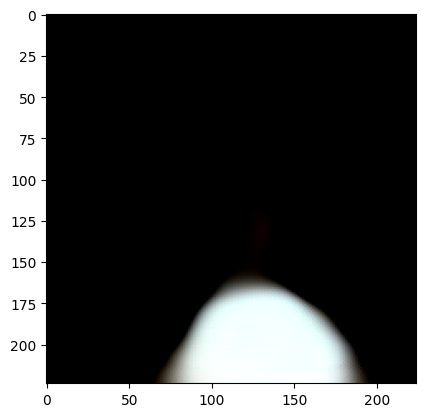

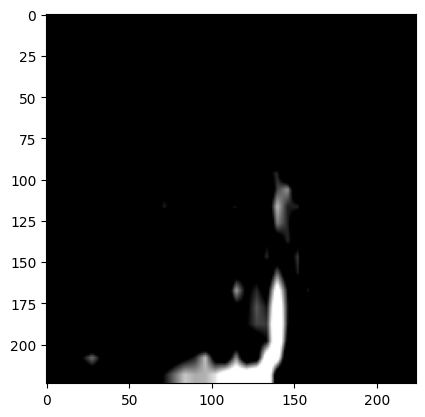

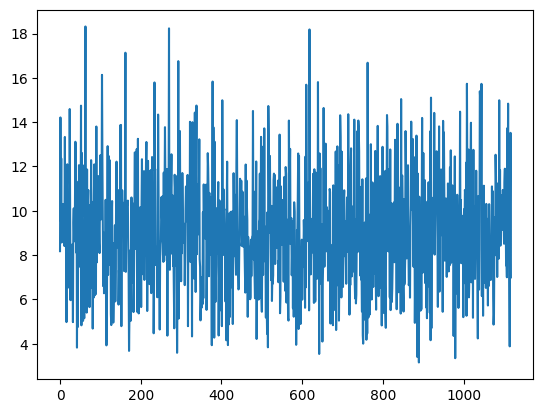

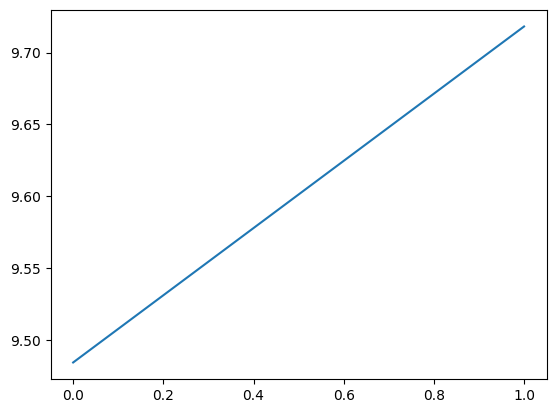

  2%|███████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 2/100 [35:21<28:27:23, 1045.34s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b221b750>, test/blurry_pixcorr=0.468, test/loss=9.72, test/loss_clip_total=0.288, test/loss_prior=0.314, test/num_steps=2, test/test_bwd_pct_correct=0.908, test/test_fwd_pct_correct=0.913, train/blurry_pixcorr=0.798, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=9.04, train/los

[E2/100 I0/559]
  Loss 9.954607009887695
[E2/100 I50/559]
  Loss 8.405731201171875
[E2/100 I100/559]
  Loss 8.53795337677002
[E2/100 I150/559]
  Loss 4.852863311767578
[E2/100 I200/559]
  Loss 3.959822654724121
[E2/100 I250/559]
  Loss 11.103050231933594
[E2/100 I300/559]
  Loss 7.885189056396484
[E2/100 I350/559]
  Loss 5.850160598754883
[E2/100 I400/559]
  Loss 8.341473579406738
[E2/100 I450/559]
  Loss 8.722639083862305
[E2/100 I500/559]
  Loss 7.527427673339844
[E2/100 I550/559]
  Loss 13.703458786010742

---Evaluating---



  2%|███████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 2/100 [51:26<28:27:23, 1045.34s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b20f2510>, test/blurry_pixcorr=0.468, test/loss=10.1, test/loss_clip_total=0.288, test/loss_prior=0.328, test/num_steps=3, test/test_bwd_pct_correct=0.89, test/test_fwd_pct_correct=0.902, train/blurry_pixcorr=0.795, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=9.28, train/lo


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 2 / 100


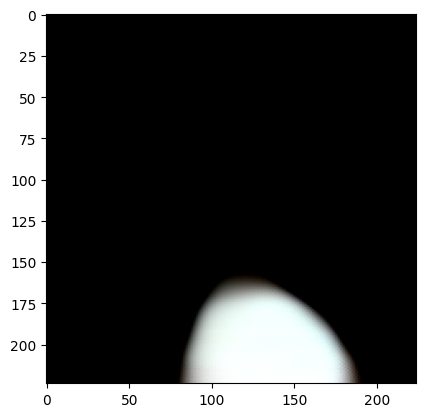

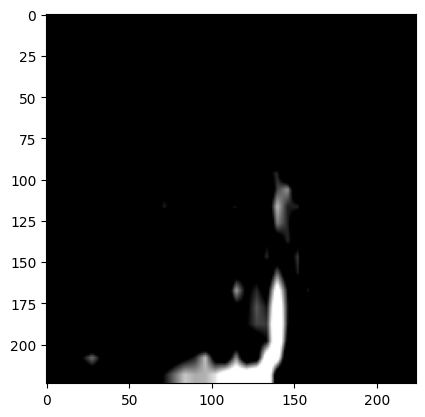

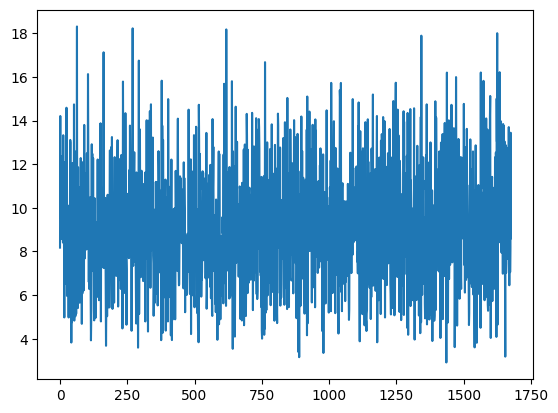

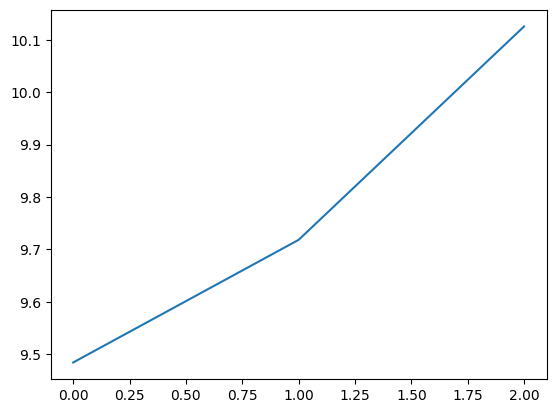

  3%|█████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 3/100 [51:33<27:16:06, 1012.02s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b20f2510>, test/blurry_pixcorr=0.468, test/loss=10.1, test/loss_clip_total=0.288, test/loss_prior=0.328, test/num_steps=3, test/test_bwd_pct_correct=0.89, test/test_fwd_pct_correct=0.902, train/blurry_pixcorr=0.795, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=9.28, train/lo

[E3/100 I0/559]
  Loss 3.260896682739258
[E3/100 I50/559]
  Loss 12.97261905670166
[E3/100 I100/559]
  Loss 5.29256534576416
[E3/100 I150/559]
  Loss 5.620196342468262
[E3/100 I200/559]
  Loss 13.549840927124023
[E3/100 I250/559]
  Loss 10.268354415893555
[E3/100 I300/559]
  Loss 10.555201530456543
[E3/100 I350/559]
  Loss 11.144266128540039
[E3/100 I400/559]
  Loss 12.753825187683105
[E3/100 I450/559]
  Loss 4.114367485046387
[E3/100 I500/559]
  Loss 11.862391471862793
[E3/100 I550/559]
  Loss 12.203459739685059

---Evaluating---



  3%|█████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 3/100 [1:07:37<27:16:06, 1012.02s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34aef9a890>, test/blurry_pixcorr=0.467, test/loss=10.5, test/loss_clip_total=0.335, test/loss_prior=0.338, test/num_steps=4, test/test_bwd_pct_correct=0.881, test/test_fwd_pct_correct=0.887, train/blurry_pixcorr=0.802, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.91, train/los


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 3 / 100


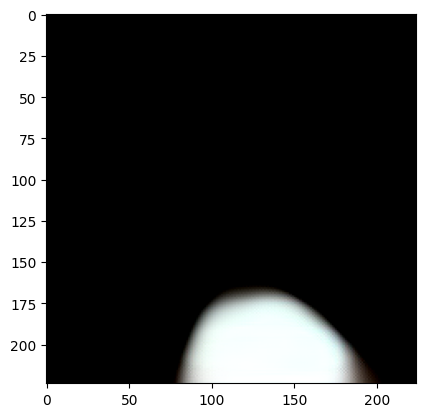

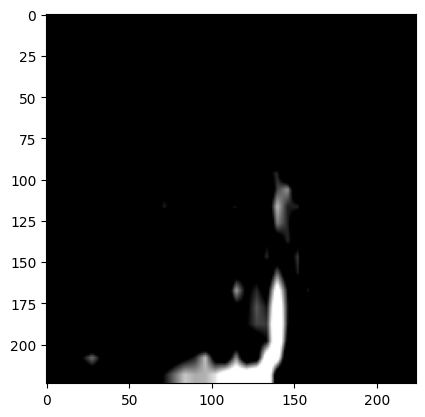

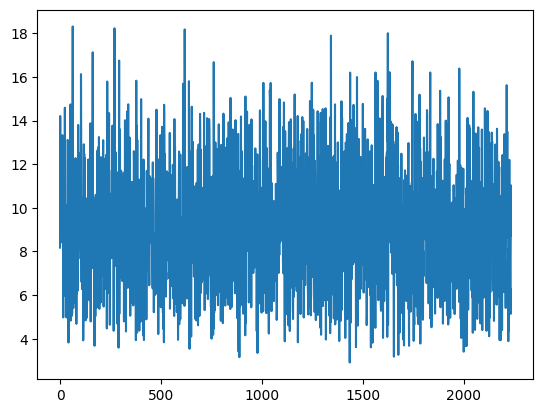

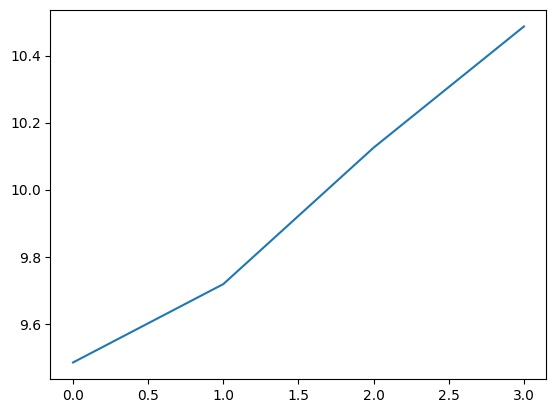

  4%|███████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 4/100 [1:07:59<26:42:26, 1001.53s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34aef9a890>, test/blurry_pixcorr=0.467, test/loss=10.5, test/loss_clip_total=0.335, test/loss_prior=0.338, test/num_steps=4, test/test_bwd_pct_correct=0.881, test/test_fwd_pct_correct=0.887, train/blurry_pixcorr=0.802, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.91, train/los

[E4/100 I0/559]
  Loss 10.275349617004395
[E4/100 I50/559]
  Loss 9.917488098144531
[E4/100 I100/559]
  Loss 10.206829071044922
[E4/100 I150/559]
  Loss 9.51441764831543
[E4/100 I200/559]
  Loss 13.887694358825684
[E4/100 I250/559]
  Loss 10.894484519958496
[E4/100 I300/559]
  Loss 5.480396747589111
[E4/100 I350/559]
  Loss 5.322842121124268
[E4/100 I400/559]
  Loss 10.785734176635742
[E4/100 I450/559]
  Loss 10.875650405883789
[E4/100 I500/559]
  Loss 10.022872924804688
[E4/100 I550/559]
  Loss 8.972464561462402

---Evaluating---



  4%|███████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 4/100 [1:24:04<26:42:26, 1001.53s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34aeee2e10>, test/blurry_pixcorr=0.467, test/loss=10.6, test/loss_clip_total=0.303, test/loss_prior=0.343, test/num_steps=5, test/test_bwd_pct_correct=0.892, test/test_fwd_pct_correct=0.896, train/blurry_pixcorr=0.812, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.95, train/los


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/ep4 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 4 / 100


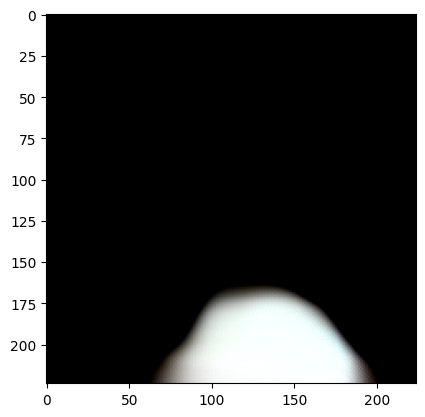

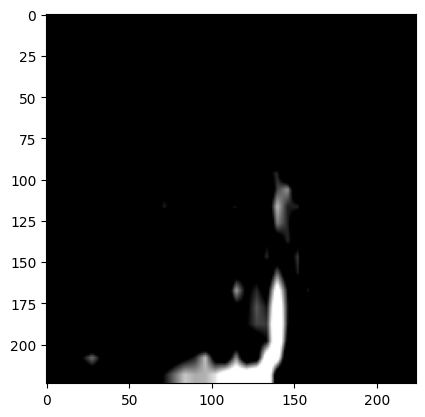

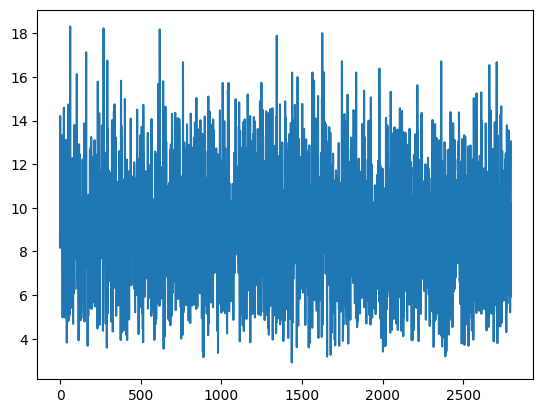

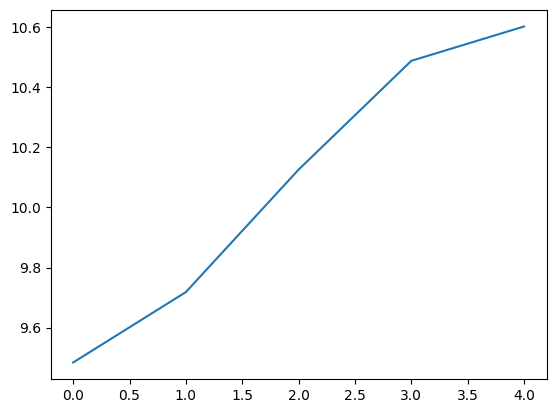

  5%|█████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 5/100 [1:24:18<26:13:03, 993.51s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34aeee2e10>, test/blurry_pixcorr=0.467, test/loss=10.6, test/loss_clip_total=0.303, test/loss_prior=0.343, test/num_steps=5, test/test_bwd_pct_correct=0.892, test/test_fwd_pct_correct=0.896, train/blurry_pixcorr=0.812, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.95, train/los

[E5/100 I0/559]
  Loss 8.400126457214355
[E5/100 I50/559]
  Loss 9.459434509277344
[E5/100 I100/559]
  Loss 12.672391891479492
[E5/100 I150/559]
  Loss 8.94289779663086
[E5/100 I200/559]
  Loss 9.457276344299316
[E5/100 I250/559]
  Loss 9.279510498046875
[E5/100 I300/559]
  Loss 7.794267654418945
[E5/100 I350/559]
  Loss 11.904034614562988
[E5/100 I400/559]
  Loss 8.13174057006836
[E5/100 I450/559]
  Loss 9.281010627746582
[E5/100 I500/559]
  Loss 4.543715476989746
[E5/100 I550/559]
  Loss 7.892157077789307

---Evaluating---



  5%|██████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 5/100 [1:40:23<26:13:03, 993.51s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b2370650>, test/blurry_pixcorr=0.469, test/loss=10.2, test/loss_clip_total=0.297, test/loss_prior=0.33, test/num_steps=6, test/test_bwd_pct_correct=0.9, test/test_fwd_pct_correct=0.9, train/blurry_pixcorr=0.816, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.93, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 5 / 100


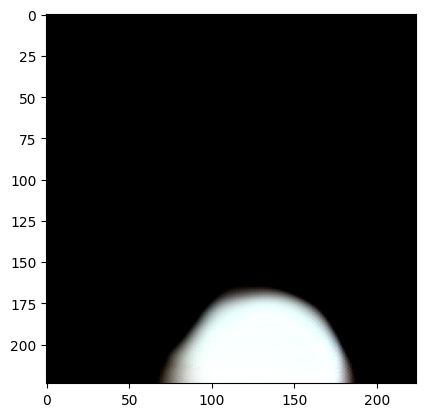

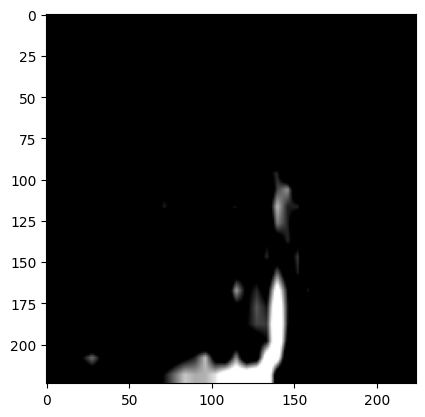

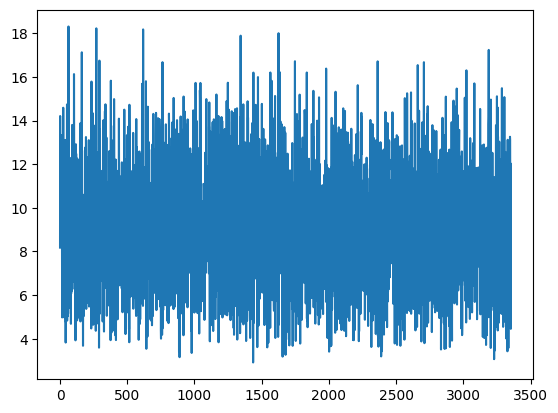

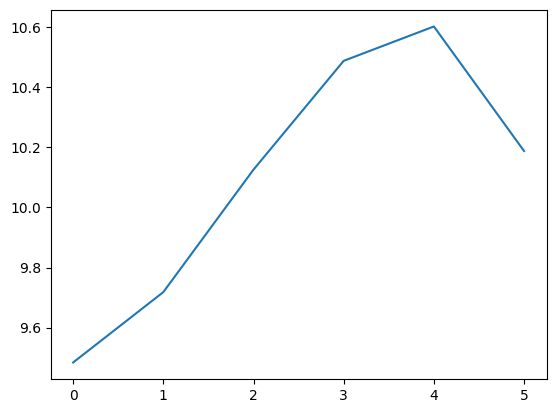

  6%|████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 6/100 [1:40:30<25:45:12, 986.30s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b2370650>, test/blurry_pixcorr=0.469, test/loss=10.2, test/loss_clip_total=0.297, test/loss_prior=0.33, test/num_steps=6, test/test_bwd_pct_correct=0.9, test/test_fwd_pct_correct=0.9, train/blurry_pixcorr=0.816, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.93, train/loss

[E6/100 I0/559]
  Loss 8.374213218688965
[E6/100 I50/559]
  Loss 4.2116007804870605
[E6/100 I100/559]
  Loss 9.691496849060059
[E6/100 I150/559]
  Loss 6.710269451141357
[E6/100 I200/559]
  Loss 8.925153732299805
[E6/100 I250/559]
  Loss 7.988497257232666
[E6/100 I300/559]
  Loss 12.152315139770508
[E6/100 I350/559]
  Loss 9.132340431213379
[E6/100 I400/559]
  Loss 7.436371326446533
[E6/100 I450/559]
  Loss 10.608491897583008
[E6/100 I500/559]
  Loss 10.664058685302734
[E6/100 I550/559]
  Loss 8.239476203918457

---Evaluating---



  6%|███████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 6/100 [1:56:36<25:45:12, 986.30s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b2170550>, test/blurry_pixcorr=0.467, test/loss=10.3, test/loss_clip_total=0.304, test/loss_prior=0.333, test/num_steps=7, test/test_bwd_pct_correct=0.908, test/test_fwd_pct_correct=0.904, train/blurry_pixcorr=0.816, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.74, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 6 / 100


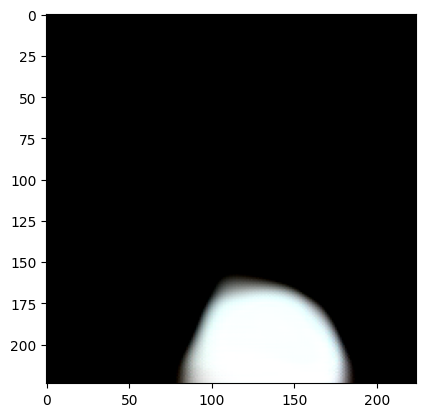

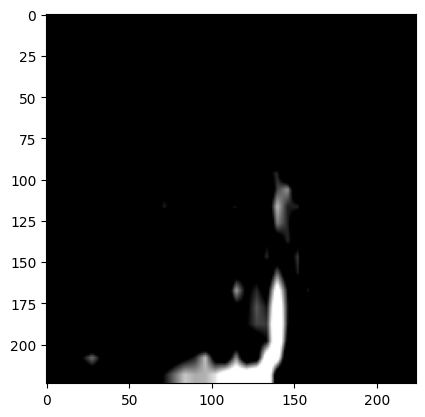

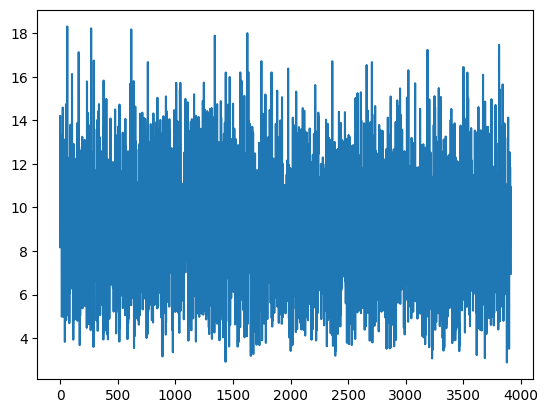

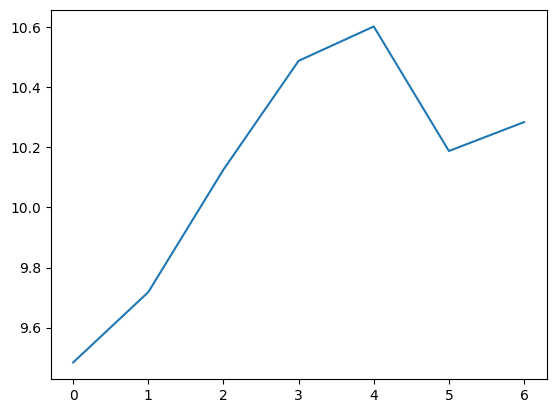

  7%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 7/100 [1:56:44<25:22:29, 982.25s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b2170550>, test/blurry_pixcorr=0.467, test/loss=10.3, test/loss_clip_total=0.304, test/loss_prior=0.333, test/num_steps=7, test/test_bwd_pct_correct=0.908, test/test_fwd_pct_correct=0.904, train/blurry_pixcorr=0.816, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.74, train/loss

[E7/100 I0/559]
  Loss 5.575664520263672
[E7/100 I50/559]
  Loss 8.115711212158203
[E7/100 I100/559]
  Loss 6.660707473754883
[E7/100 I150/559]
  Loss 7.865636825561523
[E7/100 I200/559]
  Loss 8.693922996520996
[E7/100 I250/559]
  Loss 8.315410614013672
[E7/100 I300/559]
  Loss 10.292926788330078
[E7/100 I350/559]
  Loss 7.154562950134277
[E7/100 I400/559]
  Loss 11.21426010131836
[E7/100 I450/559]
  Loss 8.703145027160645
[E7/100 I500/559]
  Loss 8.298798561096191
[E7/100 I550/559]
  Loss 9.173981666564941

---Evaluating---



  7%|█████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 7/100 [2:12:54<25:22:29, 982.25s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f350d0d2010>, test/blurry_pixcorr=0.463, test/loss=10.7, test/loss_clip_total=0.315, test/loss_prior=0.345, test/num_steps=8, test/test_bwd_pct_correct=0.915, test/test_fwd_pct_correct=0.9, train/blurry_pixcorr=0.825, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.78, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 7 / 100


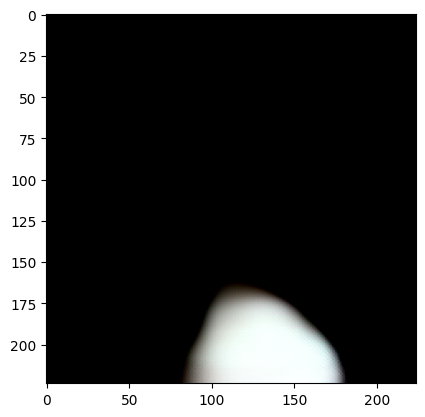

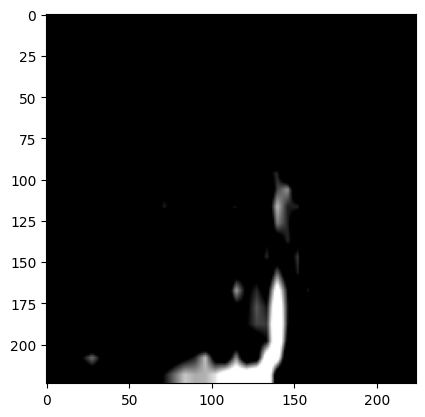

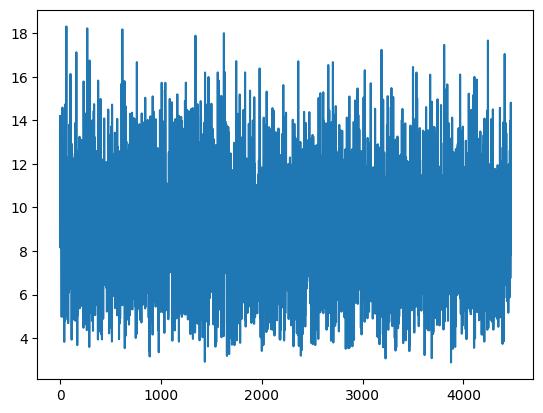

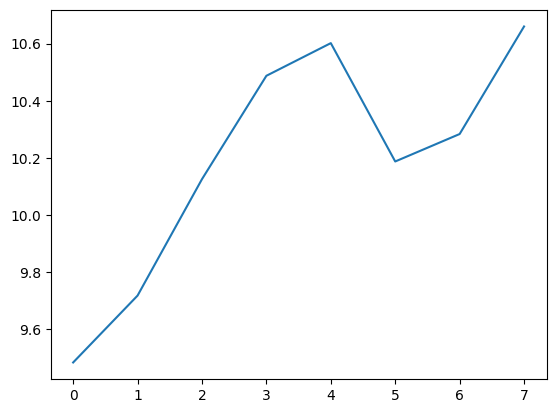

  8%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 8/100 [2:13:02<25:03:52, 980.79s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f350d0d2010>, test/blurry_pixcorr=0.463, test/loss=10.7, test/loss_clip_total=0.315, test/loss_prior=0.345, test/num_steps=8, test/test_bwd_pct_correct=0.915, test/test_fwd_pct_correct=0.9, train/blurry_pixcorr=0.825, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.78, train/loss

[E8/100 I0/559]
  Loss 7.725234031677246
[E8/100 I50/559]
  Loss 4.192293643951416
[E8/100 I100/559]
  Loss 9.214136123657227
[E8/100 I150/559]
  Loss 11.0536527633667
[E8/100 I200/559]
  Loss 10.1666898727417
[E8/100 I250/559]
  Loss 16.194232940673828
[E8/100 I300/559]
  Loss 7.460262298583984
[E8/100 I350/559]
  Loss 10.828495979309082
[E8/100 I400/559]
  Loss 8.164840698242188
[E8/100 I450/559]
  Loss 5.881524562835693
[E8/100 I500/559]
  Loss 8.877524375915527
[E8/100 I550/559]
  Loss 8.344810485839844

---Evaluating---



  8%|███████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 8/100 [2:29:10<25:03:52, 980.79s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b378e490>, test/blurry_pixcorr=0.465, test/loss=10.1, test/loss_clip_total=0.315, test/loss_prior=0.327, test/num_steps=9, test/test_bwd_pct_correct=0.908, test/test_fwd_pct_correct=0.892, train/blurry_pixcorr=0.823, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.87, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 8 / 100


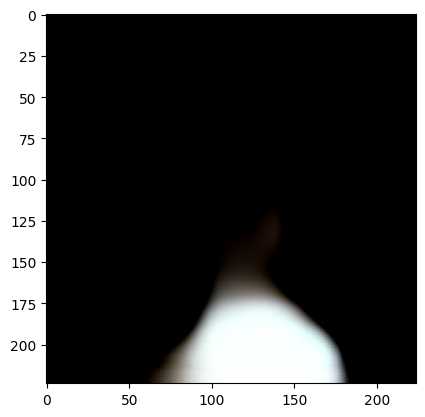

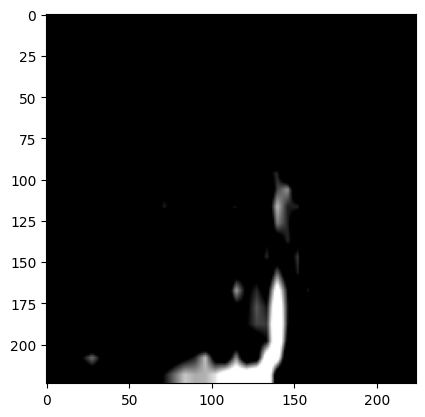

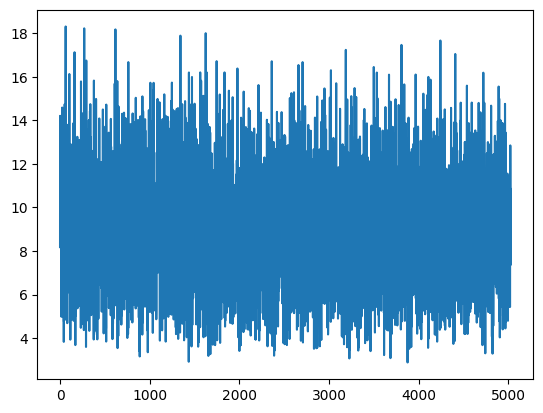

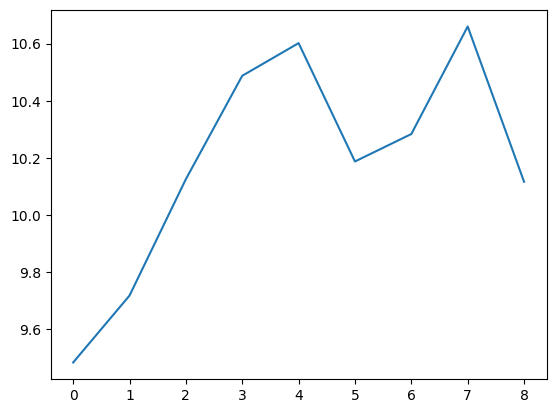

  9%|█████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | 9/100 [2:29:34<24:52:43, 984.22s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b378e490>, test/blurry_pixcorr=0.465, test/loss=10.1, test/loss_clip_total=0.315, test/loss_prior=0.327, test/num_steps=9, test/test_bwd_pct_correct=0.908, test/test_fwd_pct_correct=0.892, train/blurry_pixcorr=0.823, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.87, train/loss

[E9/100 I0/559]
  Loss 9.606077194213867
[E9/100 I50/559]
  Loss 8.979133605957031
[E9/100 I100/559]
  Loss 5.112595558166504
[E9/100 I150/559]
  Loss 8.143138885498047
[E9/100 I200/559]
  Loss 6.185617446899414
[E9/100 I250/559]
  Loss 4.8139872550964355
[E9/100 I300/559]
  Loss 11.052026748657227
[E9/100 I350/559]
  Loss 18.951555252075195
[E9/100 I400/559]
  Loss 10.498650550842285
[E9/100 I450/559]
  Loss 8.059503555297852
[E9/100 I500/559]
  Loss 7.602548599243164
[E9/100 I550/559]
  Loss 9.54368782043457

---Evaluating---


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/best ckpt!---



  9%|█████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 9/100 [2:45:45<24:52:43, 984.22s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b238a350>, test/blurry_pixcorr=0.467, test/loss=9.45, test/loss_clip_total=0.331, test/loss_prior=0.304, test/num_steps=10, test/test_bwd_pct_correct=0.896, test/test_fwd_pct_correct=0.871, train/blurry_pixcorr=0.823, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.72, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/ep9 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 9 / 100


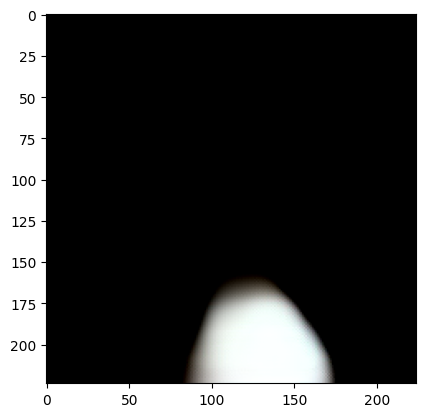

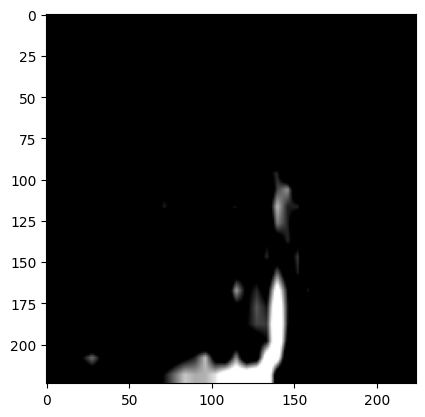

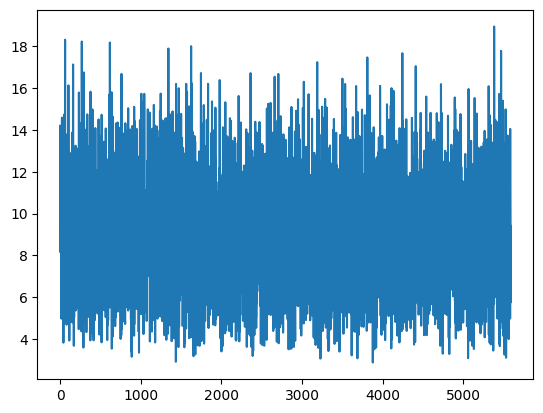

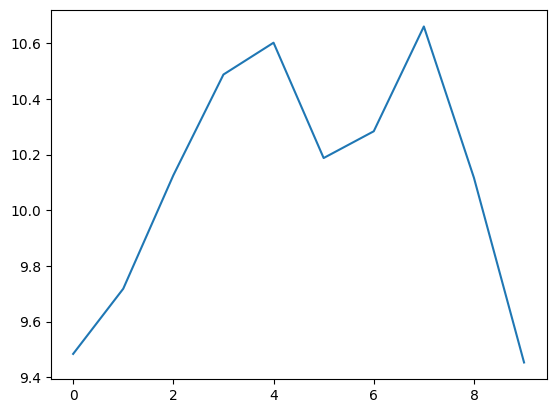

 10%|███████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 10/100 [2:46:00<24:37:33, 985.04s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b238a350>, test/blurry_pixcorr=0.467, test/loss=9.45, test/loss_clip_total=0.331, test/loss_prior=0.304, test/num_steps=10, test/test_bwd_pct_correct=0.896, test/test_fwd_pct_correct=0.871, train/blurry_pixcorr=0.823, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.72, train/loss

[E10/100 I0/559]
  Loss 10.9879789352417
[E10/100 I50/559]
  Loss 13.744274139404297
[E10/100 I100/559]
  Loss 11.724430084228516
[E10/100 I150/559]
  Loss 10.132282257080078
[E10/100 I200/559]
  Loss 5.389438629150391
[E10/100 I250/559]
  Loss 7.069873809814453
[E10/100 I300/559]
  Loss 8.65492057800293
[E10/100 I350/559]
  Loss 12.52525806427002
[E10/100 I400/559]
  Loss 5.971442222595215
[E10/100 I450/559]
  Loss 8.5964994430542
[E10/100 I500/559]
  Loss 6.936999320983887
[E10/100 I550/559]
  Loss 11.419326782226562

---Evaluating---



 10%|███████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 10/100 [3:02:07<24:37:33, 985.04s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34ae223cd0>, test/blurry_pixcorr=0.464, test/loss=9.88, test/loss_clip_total=0.301, test/loss_prior=0.319, test/num_steps=11, test/test_bwd_pct_correct=0.896, test/test_fwd_pct_correct=0.902, train/blurry_pixcorr=0.831, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.62, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 10 / 100


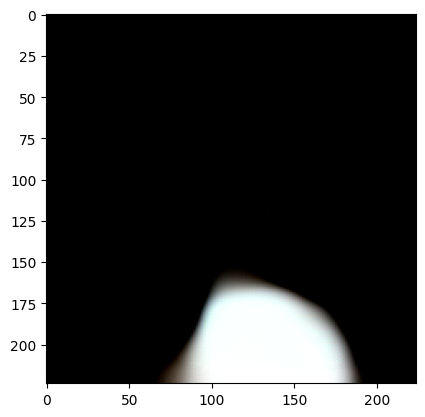

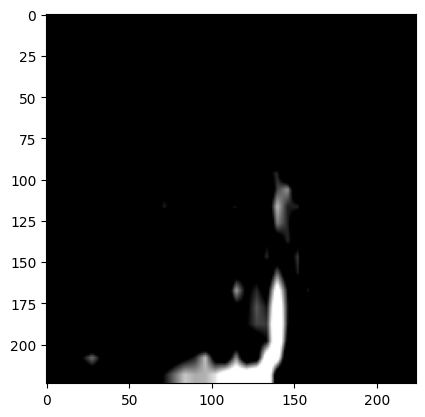

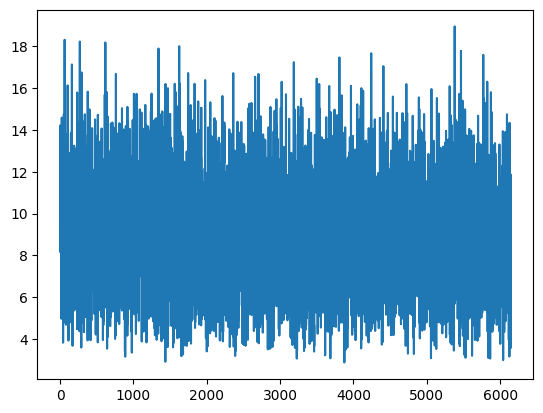

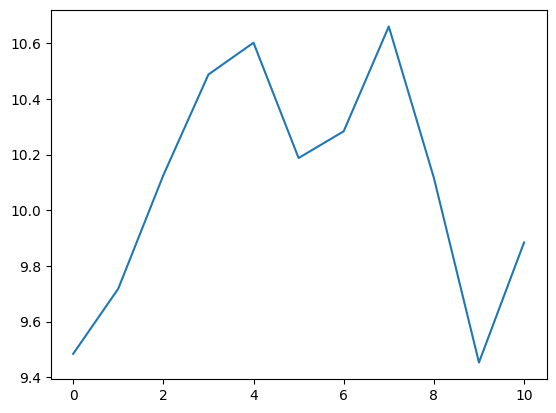

 11%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 11/100 [3:02:15<24:16:14, 981.73s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34ae223cd0>, test/blurry_pixcorr=0.464, test/loss=9.88, test/loss_clip_total=0.301, test/loss_prior=0.319, test/num_steps=11, test/test_bwd_pct_correct=0.896, test/test_fwd_pct_correct=0.902, train/blurry_pixcorr=0.831, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.62, train/loss

[E11/100 I0/559]
  Loss 8.990097045898438
[E11/100 I50/559]
  Loss 8.715866088867188
[E11/100 I100/559]
  Loss 7.8543500900268555
[E11/100 I150/559]
  Loss 7.040652275085449
[E11/100 I200/559]
  Loss 7.374887943267822
[E11/100 I250/559]
  Loss 5.365440368652344
[E11/100 I300/559]
  Loss 9.066615104675293
[E11/100 I350/559]
  Loss 8.758025169372559
[E11/100 I400/559]
  Loss 9.325511932373047
[E11/100 I450/559]
  Loss 12.245573997497559
[E11/100 I500/559]
  Loss 6.464184284210205
[E11/100 I550/559]
  Loss 10.1123628616333

---Evaluating---



 11%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 11/100 [3:18:21<24:16:14, 981.73s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b37d7e10>, test/blurry_pixcorr=0.465, test/loss=9.71, test/loss_clip_total=0.324, test/loss_prior=0.313, test/num_steps=12, test/test_bwd_pct_correct=0.881, test/test_fwd_pct_correct=0.906, train/blurry_pixcorr=0.83, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.62, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 11 / 100


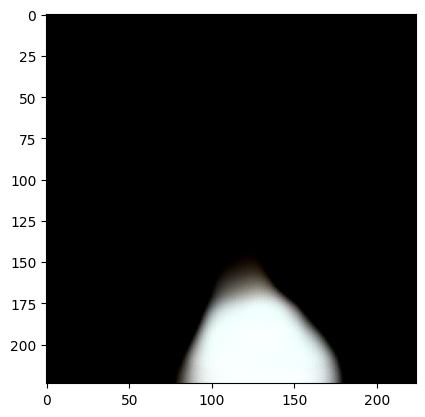

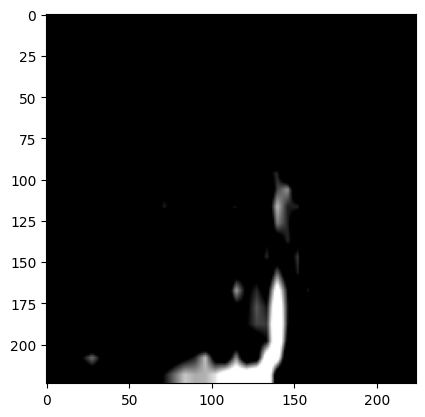

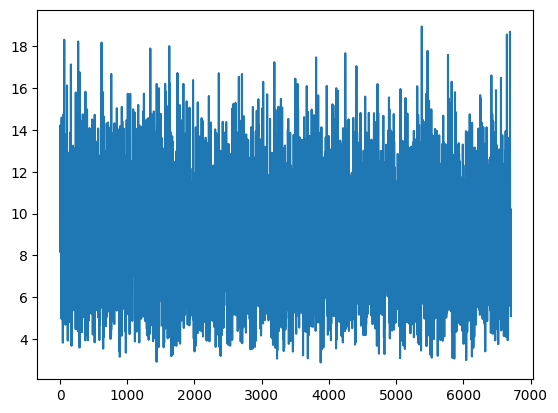

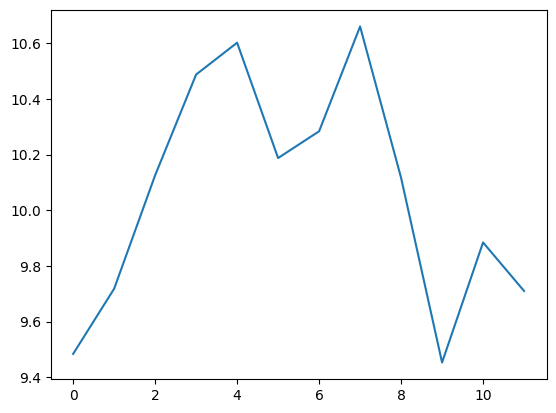

 12%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 12/100 [3:18:29<23:56:47, 979.63s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b37d7e10>, test/blurry_pixcorr=0.465, test/loss=9.71, test/loss_clip_total=0.324, test/loss_prior=0.313, test/num_steps=12, test/test_bwd_pct_correct=0.881, test/test_fwd_pct_correct=0.906, train/blurry_pixcorr=0.83, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.62, train/loss

[E12/100 I0/559]
  Loss 8.921441078186035
[E12/100 I50/559]
  Loss 10.904336929321289
[E12/100 I100/559]
  Loss 7.172657489776611
[E12/100 I150/559]
  Loss 4.926682949066162
[E12/100 I200/559]
  Loss 13.726810455322266
[E12/100 I250/559]
  Loss 6.640410423278809
[E12/100 I300/559]
  Loss 8.762442588806152
[E12/100 I350/559]
  Loss 9.752580642700195
[E12/100 I400/559]
  Loss 9.49154281616211
[E12/100 I450/559]
  Loss 9.69072151184082
[E12/100 I500/559]
  Loss 9.338233947753906
[E12/100 I550/559]
  Loss 9.50185775756836

---Evaluating---



 12%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 12/100 [3:34:38<23:56:47, 979.63s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b2336610>, test/blurry_pixcorr=0.464, test/loss=10.3, test/loss_clip_total=0.315, test/loss_prior=0.333, test/num_steps=13, test/test_bwd_pct_correct=0.91, test/test_fwd_pct_correct=0.885, train/blurry_pixcorr=0.835, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.54, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 12 / 100


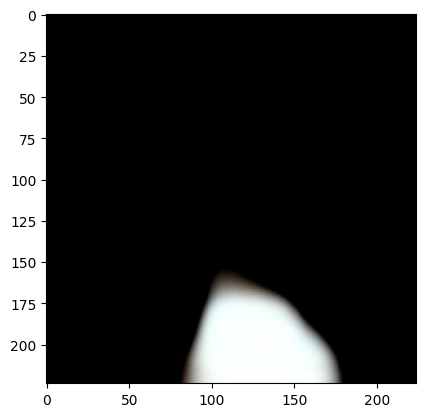

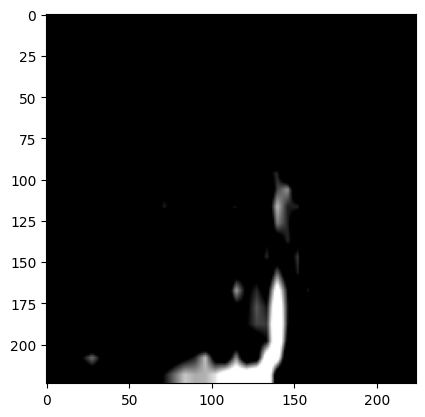

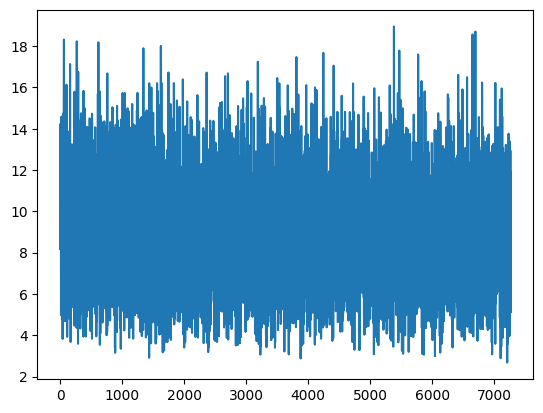

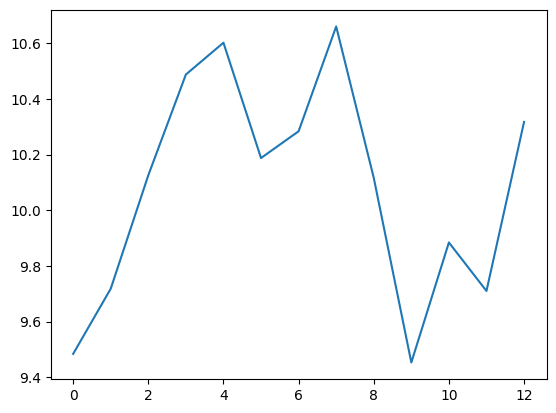

 13%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 13/100 [3:34:52<23:41:39, 980.46s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b2336610>, test/blurry_pixcorr=0.464, test/loss=10.3, test/loss_clip_total=0.315, test/loss_prior=0.333, test/num_steps=13, test/test_bwd_pct_correct=0.91, test/test_fwd_pct_correct=0.885, train/blurry_pixcorr=0.835, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.54, train/loss_

[E13/100 I0/559]
  Loss 9.838961601257324
[E13/100 I50/559]
  Loss 8.932526588439941
[E13/100 I100/559]
  Loss 7.523500919342041
[E13/100 I150/559]
  Loss 8.817849159240723
[E13/100 I200/559]
  Loss 8.209793090820312
[E13/100 I250/559]
  Loss 6.482399940490723
[E13/100 I300/559]
  Loss 6.511212348937988
[E13/100 I350/559]
  Loss 9.300464630126953
[E13/100 I400/559]
  Loss 3.3649284839630127
[E13/100 I450/559]
  Loss 7.360289573669434
[E13/100 I500/559]
  Loss 11.071466445922852
[E13/100 I550/559]
  Loss 11.424612045288086

---Evaluating---



 13%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 13/100 [3:51:03<23:41:39, 980.46s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b2156210>, test/blurry_pixcorr=0.464, test/loss=10.5, test/loss_clip_total=0.301, test/loss_prior=0.341, test/num_steps=14, test/test_bwd_pct_correct=0.894, test/test_fwd_pct_correct=0.896, train/blurry_pixcorr=0.836, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.34, train/lo


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 13 / 100


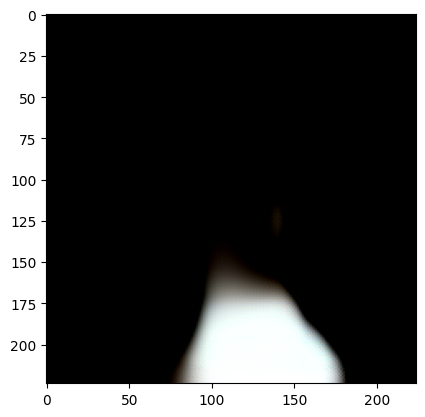

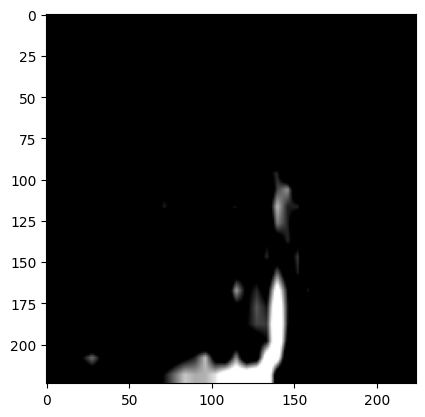

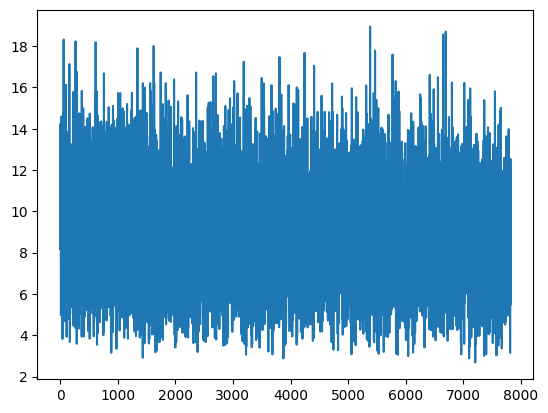

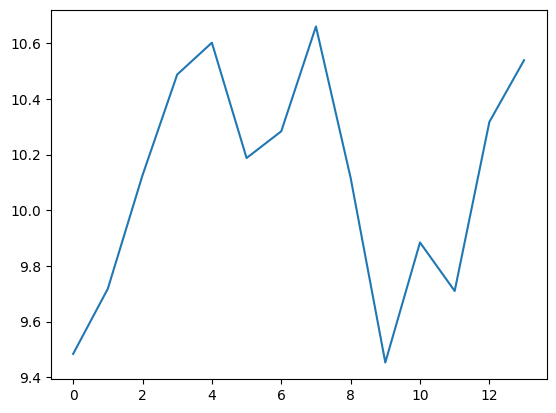

 14%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 14/100 [3:51:24<23:30:18, 983.94s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b2156210>, test/blurry_pixcorr=0.464, test/loss=10.5, test/loss_clip_total=0.301, test/loss_prior=0.341, test/num_steps=14, test/test_bwd_pct_correct=0.894, test/test_fwd_pct_correct=0.896, train/blurry_pixcorr=0.836, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.34, train/lo

[E14/100 I0/559]
  Loss 10.783267974853516
[E14/100 I50/559]
  Loss 8.140528678894043
[E14/100 I100/559]
  Loss 4.284841060638428
[E14/100 I150/559]
  Loss 5.158210277557373
[E14/100 I200/559]
  Loss 4.821882247924805
[E14/100 I250/559]
  Loss 10.808452606201172
[E14/100 I300/559]
  Loss 7.050810813903809
[E14/100 I350/559]
  Loss 8.480573654174805
[E14/100 I400/559]
  Loss 12.515650749206543
[E14/100 I450/559]
  Loss 11.511751174926758
[E14/100 I500/559]
  Loss 5.325728416442871
[E14/100 I550/559]
  Loss 7.844719409942627

---Evaluating---



 14%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 14/100 [4:07:30<23:30:18, 983.94s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34aeef65d0>, test/blurry_pixcorr=0.465, test/loss=10.4, test/loss_clip_total=0.296, test/loss_prior=0.337, test/num_steps=15, test/test_bwd_pct_correct=0.894, test/test_fwd_pct_correct=0.904, train/blurry_pixcorr=0.836, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.23, train/lo


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/ep14 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 14 / 100


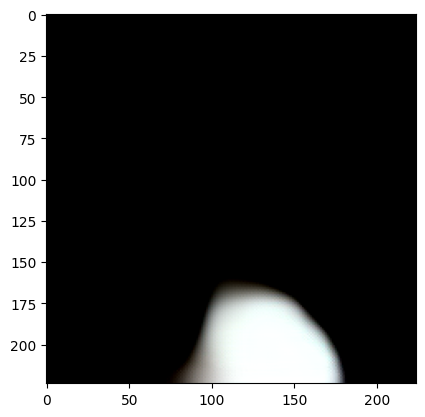

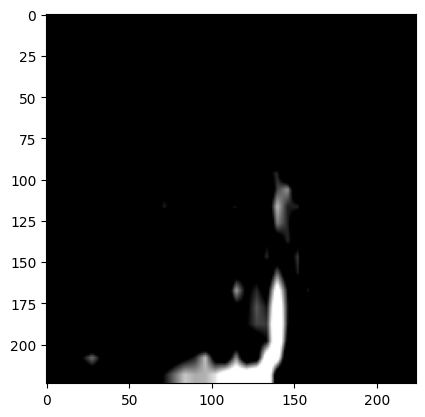

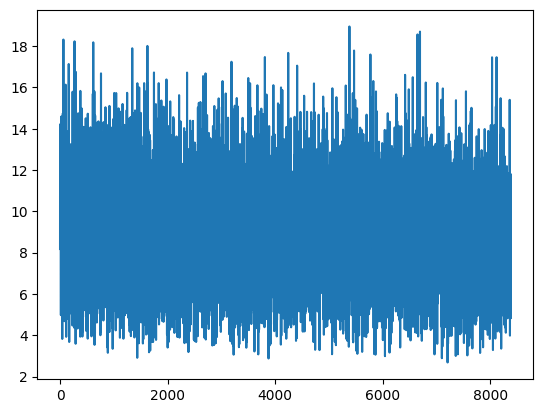

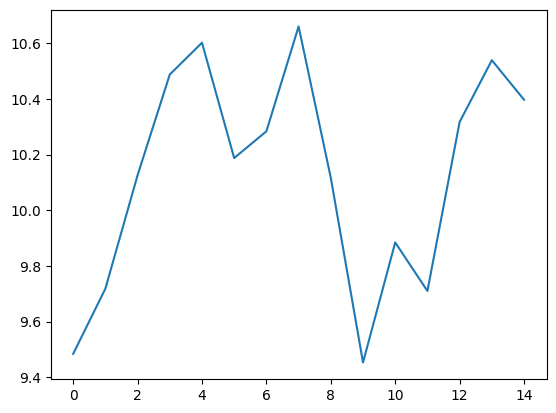

 15%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 15/100 [4:07:44<23:12:11, 982.72s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34aeef65d0>, test/blurry_pixcorr=0.465, test/loss=10.4, test/loss_clip_total=0.296, test/loss_prior=0.337, test/num_steps=15, test/test_bwd_pct_correct=0.894, test/test_fwd_pct_correct=0.904, train/blurry_pixcorr=0.836, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.23, train/lo

[E15/100 I0/559]
  Loss 8.550251007080078
[E15/100 I50/559]
  Loss 11.094818115234375
[E15/100 I100/559]
  Loss 6.171634197235107
[E15/100 I150/559]
  Loss 4.155511856079102
[E15/100 I200/559]
  Loss 8.396246910095215
[E15/100 I250/559]
  Loss 8.746636390686035
[E15/100 I300/559]
  Loss 7.910331726074219
[E15/100 I350/559]
  Loss 6.497445106506348
[E15/100 I400/559]
  Loss 4.260761737823486
[E15/100 I450/559]
  Loss 9.674192428588867
[E15/100 I500/559]
  Loss 6.911493301391602
[E15/100 I550/559]
  Loss 11.370031356811523

---Evaluating---



 15%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 15/100 [4:23:55<23:12:11, 982.72s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b3465910>, test/blurry_pixcorr=0.461, test/loss=10.1, test/loss_clip_total=0.322, test/loss_prior=0.325, test/num_steps=16, test/test_bwd_pct_correct=0.883, test/test_fwd_pct_correct=0.892, train/blurry_pixcorr=0.845, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.31, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 15 / 100


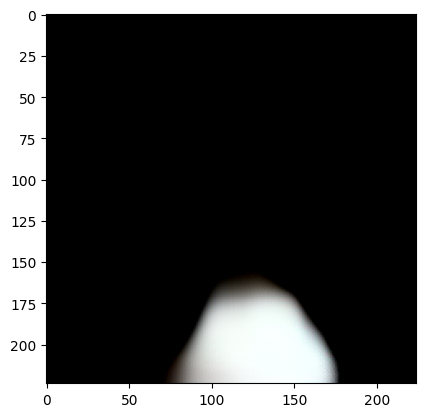

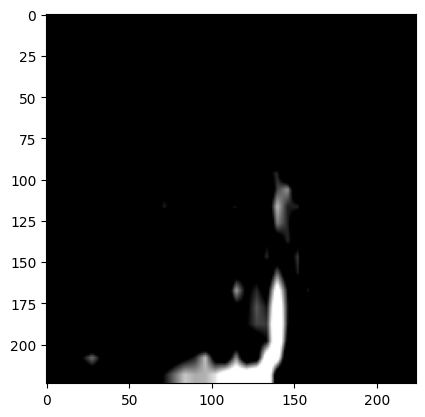

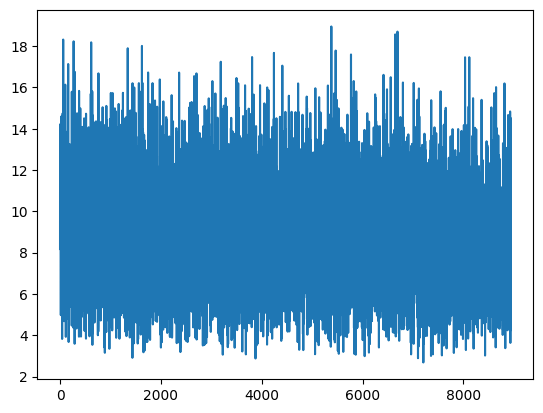

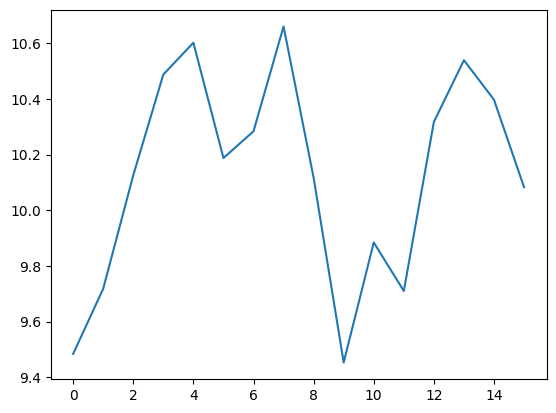

 16%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 16/100 [4:24:02<22:54:04, 981.49s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b3465910>, test/blurry_pixcorr=0.461, test/loss=10.1, test/loss_clip_total=0.322, test/loss_prior=0.325, test/num_steps=16, test/test_bwd_pct_correct=0.883, test/test_fwd_pct_correct=0.892, train/blurry_pixcorr=0.845, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.31, train/loss

[E16/100 I0/559]
  Loss 10.1232271194458
[E16/100 I50/559]
  Loss 5.412081718444824
[E16/100 I100/559]
  Loss 8.858362197875977
[E16/100 I150/559]
  Loss 6.8202056884765625
[E16/100 I200/559]
  Loss 4.168458461761475
[E16/100 I250/559]
  Loss 9.705894470214844
[E16/100 I300/559]
  Loss 10.001495361328125
[E16/100 I350/559]
  Loss 3.536039352416992
[E16/100 I400/559]
  Loss 12.300268173217773
[E16/100 I450/559]
  Loss 8.182806015014648
[E16/100 I500/559]
  Loss 8.081482887268066
[E16/100 I550/559]
  Loss 8.887130737304688

---Evaluating---



 16%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 16/100 [4:40:10<22:54:04, 981.49s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b20ae050>, test/blurry_pixcorr=0.46, test/loss=10.8, test/loss_clip_total=0.315, test/loss_prior=0.348, test/num_steps=17, test/test_bwd_pct_correct=0.883, test/test_fwd_pct_correct=0.904, train/blurry_pixcorr=0.853, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.03, train/lo


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 16 / 100


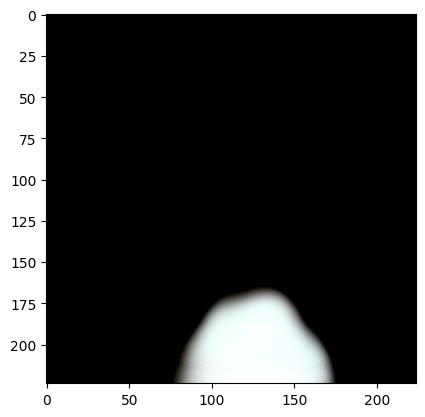

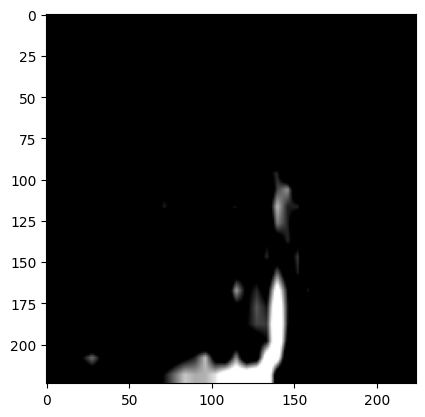

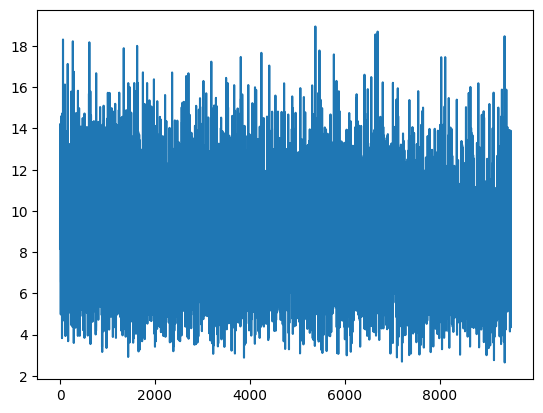

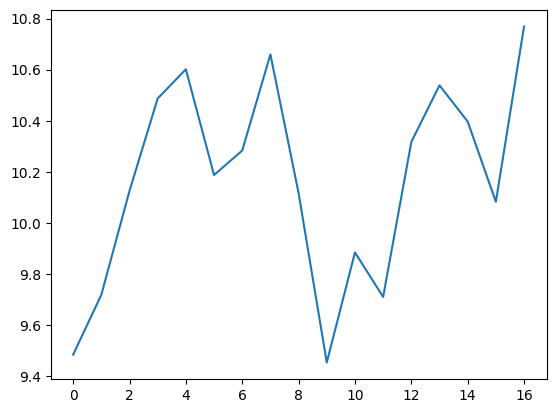

 17%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 17/100 [4:40:23<22:37:24, 981.25s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b20ae050>, test/blurry_pixcorr=0.46, test/loss=10.8, test/loss_clip_total=0.315, test/loss_prior=0.348, test/num_steps=17, test/test_bwd_pct_correct=0.883, test/test_fwd_pct_correct=0.904, train/blurry_pixcorr=0.853, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.03, train/lo

[E17/100 I0/559]
  Loss 10.399024963378906
[E17/100 I50/559]
  Loss 9.120367050170898
[E17/100 I100/559]
  Loss 8.304378509521484
[E17/100 I150/559]
  Loss 6.016260147094727
[E17/100 I200/559]
  Loss 8.556156158447266
[E17/100 I250/559]
  Loss 11.874443054199219
[E17/100 I300/559]
  Loss 9.056207656860352
[E17/100 I350/559]
  Loss 8.607565879821777
[E17/100 I400/559]
  Loss 7.244112491607666
[E17/100 I450/559]
  Loss 6.157365798950195
[E17/100 I500/559]
  Loss 8.702399253845215
[E17/100 I550/559]
  Loss 8.25322151184082

---Evaluating---



 17%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 17/100 [4:56:33<22:37:24, 981.25s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34aef1de90>, test/blurry_pixcorr=0.461, test/loss=11.7, test/loss_clip_total=0.361, test/loss_prior=0.377, test/num_steps=18, test/test_bwd_pct_correct=0.873, test/test_fwd_pct_correct=0.875, train/blurry_pixcorr=0.851, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.18, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 17 / 100


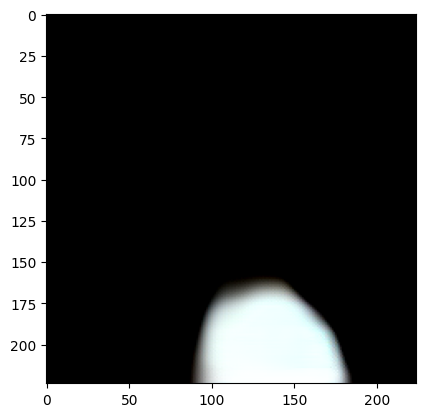

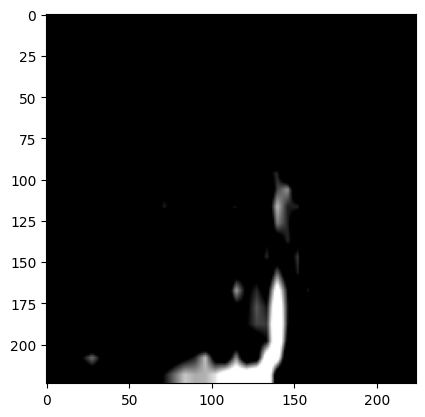

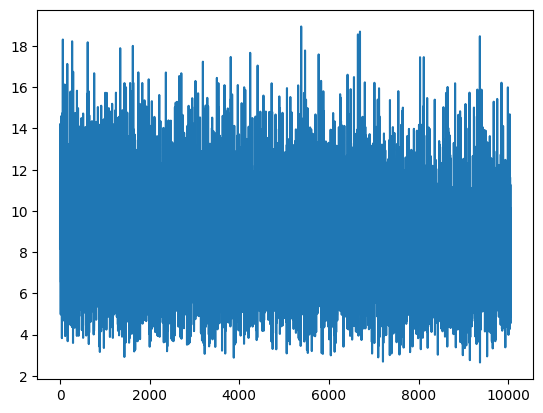

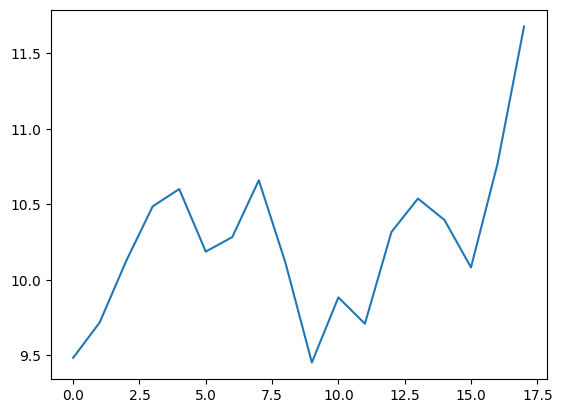

 18%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 18/100 [4:56:41<22:19:32, 980.15s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34aef1de90>, test/blurry_pixcorr=0.461, test/loss=11.7, test/loss_clip_total=0.361, test/loss_prior=0.377, test/num_steps=18, test/test_bwd_pct_correct=0.873, test/test_fwd_pct_correct=0.875, train/blurry_pixcorr=0.851, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.18, train/loss_

[E18/100 I0/559]
  Loss 10.567374229431152
[E18/100 I50/559]
  Loss 7.6106157302856445
[E18/100 I100/559]
  Loss 12.276127815246582
[E18/100 I150/559]
  Loss 3.777749538421631
[E18/100 I200/559]
  Loss 8.705839157104492
[E18/100 I250/559]
  Loss 8.784211158752441
[E18/100 I300/559]
  Loss 3.259779930114746
[E18/100 I350/559]
  Loss 13.896522521972656
[E18/100 I400/559]
  Loss 6.537862777709961
[E18/100 I450/559]
  Loss 6.653396129608154
[E18/100 I500/559]
  Loss 9.222932815551758
[E18/100 I550/559]
  Loss 7.480767726898193

---Evaluating---



 18%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 18/100 [5:12:45<22:19:32, 980.15s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34aee3c290>, test/blurry_pixcorr=0.46, test/loss=10.6, test/loss_clip_total=0.329, test/loss_prior=0.341, test/num_steps=19, test/test_bwd_pct_correct=0.894, test/test_fwd_pct_correct=0.898, train/blurry_pixcorr=0.848, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.13, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 18 / 100


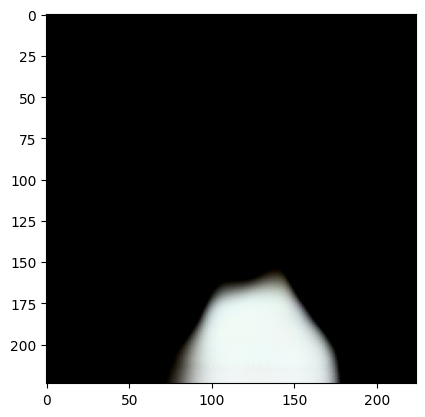

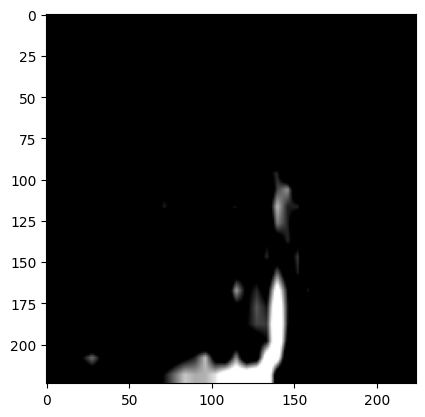

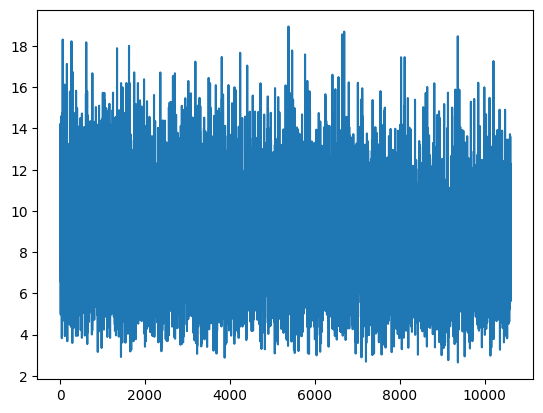

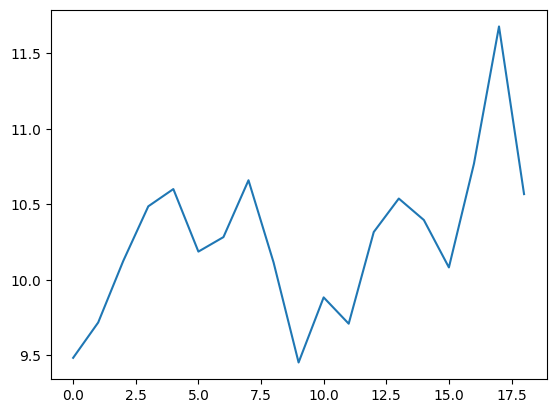

 19%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 19/100 [5:13:05<22:04:56, 981.44s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34aee3c290>, test/blurry_pixcorr=0.46, test/loss=10.6, test/loss_clip_total=0.329, test/loss_prior=0.341, test/num_steps=19, test/test_bwd_pct_correct=0.894, test/test_fwd_pct_correct=0.898, train/blurry_pixcorr=0.848, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.13, train/loss_

[E19/100 I0/559]
  Loss 9.12838077545166
[E19/100 I50/559]
  Loss 8.57012939453125
[E19/100 I100/559]
  Loss 7.746814250946045
[E19/100 I150/559]
  Loss 3.9425196647644043
[E19/100 I200/559]
  Loss 6.072882175445557
[E19/100 I250/559]
  Loss 7.320749759674072
[E19/100 I300/559]
  Loss 9.200821876525879
[E19/100 I350/559]
  Loss 4.00121545791626
[E19/100 I400/559]
  Loss 8.572861671447754
[E19/100 I450/559]
  Loss 6.97042989730835
[E19/100 I500/559]
  Loss 5.39841365814209
[E19/100 I550/559]
  Loss 9.366217613220215

---Evaluating---



 19%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 19/100 [5:29:11<22:04:56, 981.44s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b37a5810>, test/blurry_pixcorr=0.462, test/loss=10.1, test/loss_clip_total=0.412, test/loss_prior=0.324, test/num_steps=20, test/test_bwd_pct_correct=0.846, test/test_fwd_pct_correct=0.867, train/blurry_pixcorr=0.847, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.94, train/loss_b


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/ep19 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 19 / 100


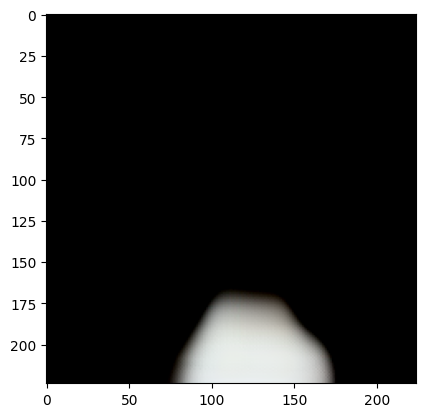

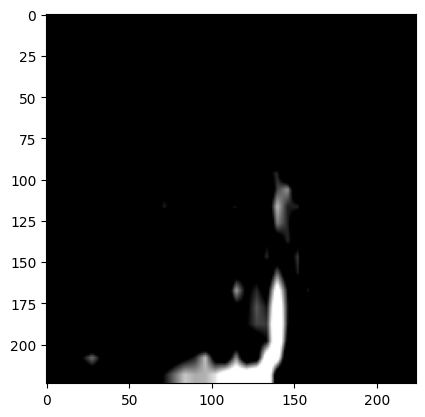

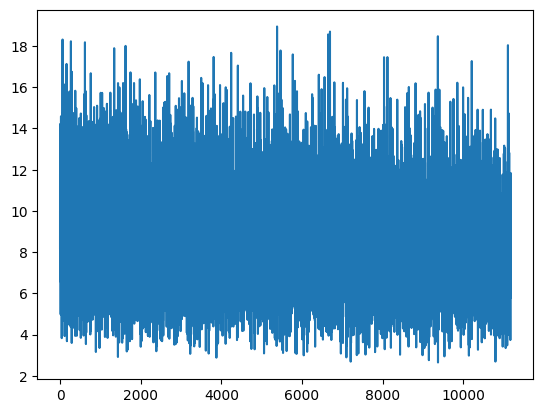

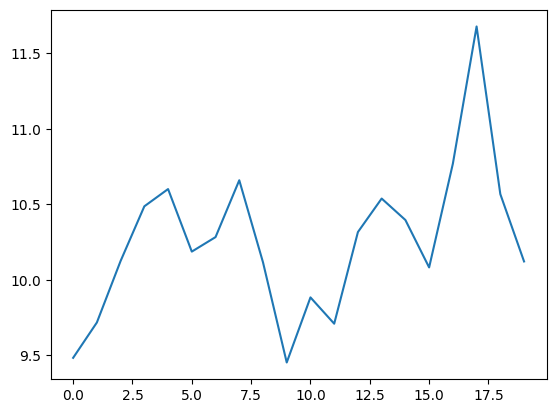

 20%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 20/100 [5:29:25<21:48:00, 981.00s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b37a5810>, test/blurry_pixcorr=0.462, test/loss=10.1, test/loss_clip_total=0.412, test/loss_prior=0.324, test/num_steps=20, test/test_bwd_pct_correct=0.846, test/test_fwd_pct_correct=0.867, train/blurry_pixcorr=0.847, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.94, train/loss_b

[E20/100 I0/559]
  Loss 7.710633754730225
[E20/100 I50/559]
  Loss 6.269328594207764
[E20/100 I100/559]
  Loss 4.889623641967773
[E20/100 I150/559]
  Loss 7.115543365478516
[E20/100 I200/559]
  Loss 10.761041641235352
[E20/100 I250/559]
  Loss 8.229812622070312
[E20/100 I300/559]
  Loss 10.946976661682129
[E20/100 I350/559]
  Loss 5.7984490394592285
[E20/100 I400/559]
  Loss 9.564637184143066
[E20/100 I450/559]
  Loss 7.9816389083862305
[E20/100 I500/559]
  Loss 7.521470069885254
[E20/100 I550/559]
  Loss 9.158185958862305

---Evaluating---



 20%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 20/100 [5:45:33<21:48:00, 981.00s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34aeea1dd0>, test/blurry_pixcorr=0.463, test/loss=10.5, test/loss_clip_total=0.351, test/loss_prior=0.338, test/num_steps=21, test/test_bwd_pct_correct=0.877, test/test_fwd_pct_correct=0.883, train/blurry_pixcorr=0.857, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 20 / 100


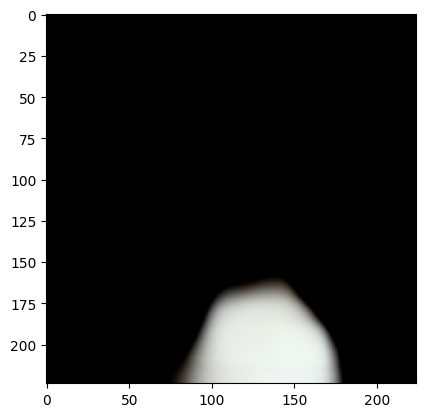

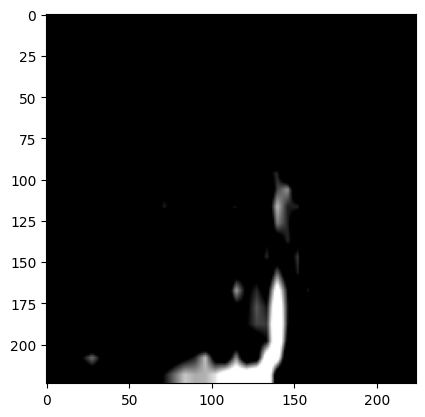

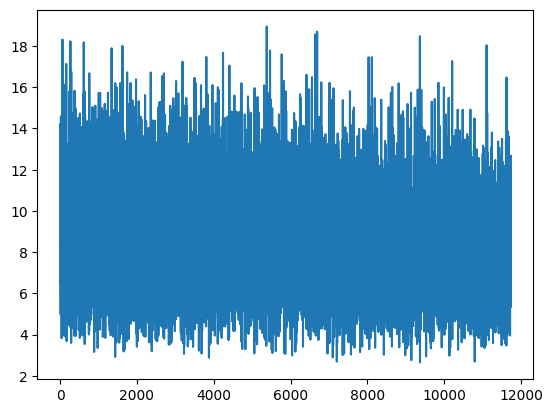

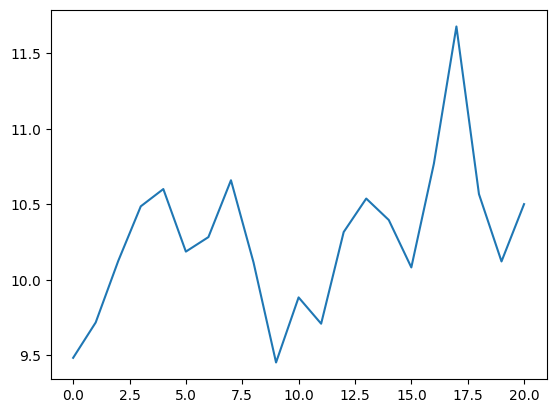

 21%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 21/100 [5:45:40<21:29:20, 979.24s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34aeea1dd0>, test/blurry_pixcorr=0.463, test/loss=10.5, test/loss_clip_total=0.351, test/loss_prior=0.338, test/num_steps=21, test/test_bwd_pct_correct=0.877, test/test_fwd_pct_correct=0.883, train/blurry_pixcorr=0.857, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8, train/loss_

[E21/100 I0/559]
  Loss 7.095597267150879
[E21/100 I50/559]
  Loss 8.01511001586914
[E21/100 I100/559]
  Loss 6.678896903991699
[E21/100 I150/559]
  Loss 10.792387008666992
[E21/100 I200/559]
  Loss 6.943316459655762
[E21/100 I250/559]
  Loss 13.08929443359375
[E21/100 I300/559]
  Loss 9.393901824951172
[E21/100 I350/559]
  Loss 8.45191478729248
[E21/100 I400/559]
  Loss 4.841847896575928
[E21/100 I450/559]
  Loss 8.879059791564941
[E21/100 I500/559]
  Loss 6.755275726318359
[E21/100 I550/559]
  Loss 8.245498657226562

---Evaluating---



 21%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 21/100 [6:01:45<21:29:20, 979.24s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b35ddb50>, test/blurry_pixcorr=0.464, test/loss=10.6, test/loss_clip_total=0.327, test/loss_prior=0.342, test/num_steps=22, test/test_bwd_pct_correct=0.885, test/test_fwd_pct_correct=0.885, train/blurry_pixcorr=0.859, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.9, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 21 / 100


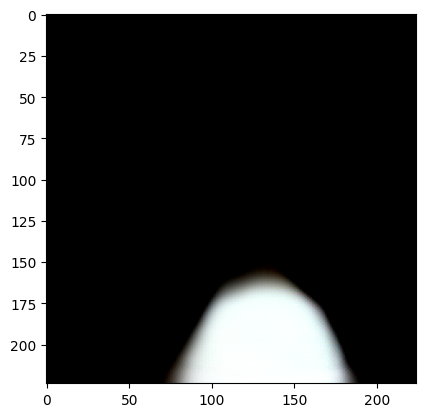

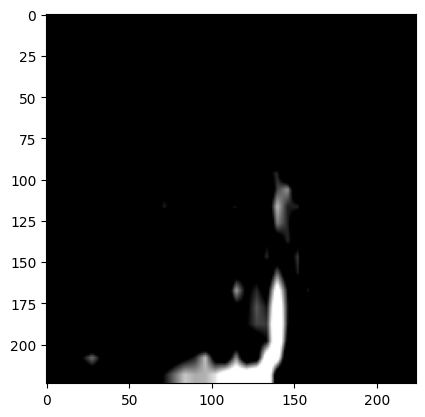

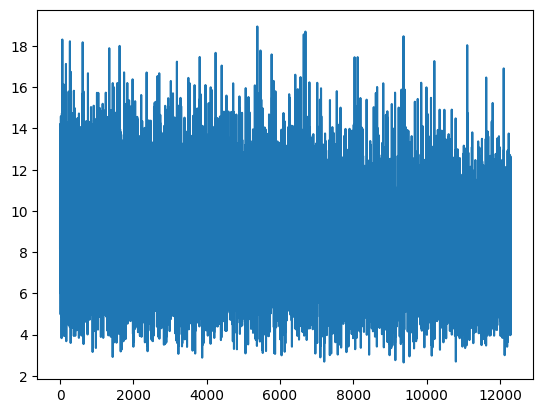

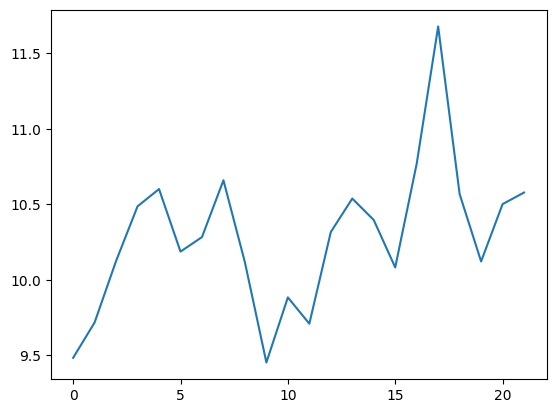

 22%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 22/100 [6:01:52<21:10:11, 977.08s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b35ddb50>, test/blurry_pixcorr=0.464, test/loss=10.6, test/loss_clip_total=0.327, test/loss_prior=0.342, test/num_steps=22, test/test_bwd_pct_correct=0.885, test/test_fwd_pct_correct=0.885, train/blurry_pixcorr=0.859, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.9, train/loss

[E22/100 I0/559]
  Loss 8.481234550476074
[E22/100 I50/559]
  Loss 10.35287857055664
[E22/100 I100/559]
  Loss 5.613831043243408
[E22/100 I150/559]
  Loss 10.028496742248535
[E22/100 I200/559]
  Loss 7.7868852615356445
[E22/100 I250/559]
  Loss 6.25054931640625
[E22/100 I300/559]
  Loss 12.291044235229492
[E22/100 I350/559]
  Loss 8.211158752441406
[E22/100 I400/559]
  Loss 7.460958957672119
[E22/100 I450/559]
  Loss 6.206814765930176
[E22/100 I500/559]
  Loss 6.3691534996032715
[E22/100 I550/559]
  Loss 6.735417366027832

---Evaluating---



 22%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 22/100 [6:17:57<21:10:11, 977.08s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b37ce1d0>, test/blurry_pixcorr=0.46, test/loss=10.5, test/loss_clip_total=0.324, test/loss_prior=0.34, test/num_steps=23, test/test_bwd_pct_correct=0.887, test/test_fwd_pct_correct=0.881, train/blurry_pixcorr=0.857, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.72, train/los


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 22 / 100


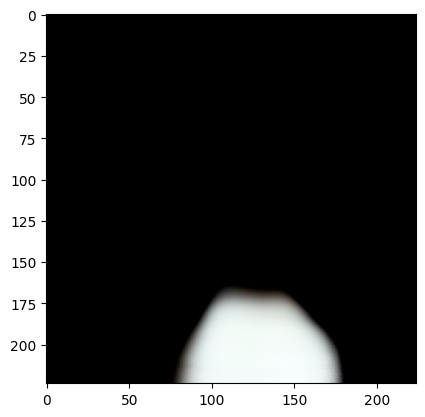

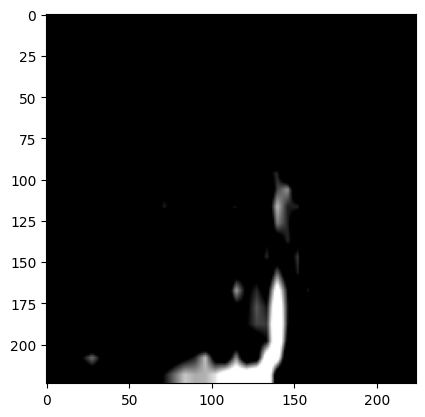

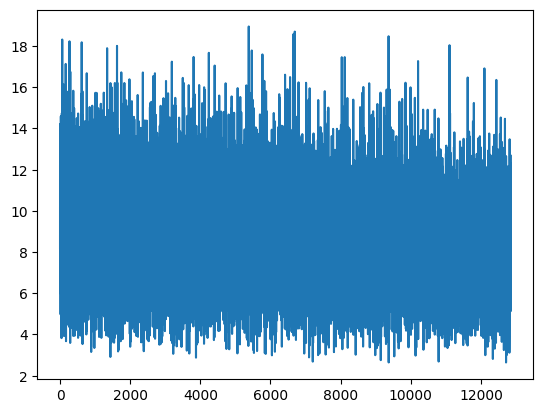

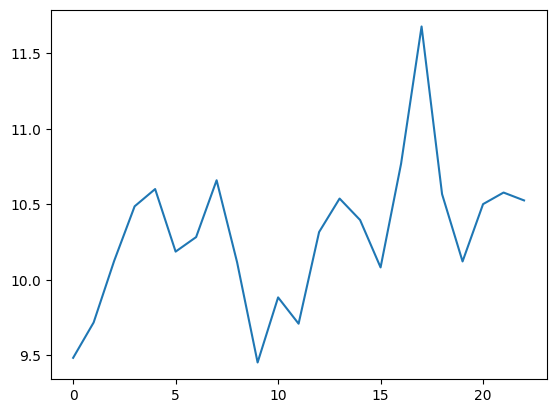

 23%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 23/100 [6:18:04<20:52:00, 975.60s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b37ce1d0>, test/blurry_pixcorr=0.46, test/loss=10.5, test/loss_clip_total=0.324, test/loss_prior=0.34, test/num_steps=23, test/test_bwd_pct_correct=0.887, test/test_fwd_pct_correct=0.881, train/blurry_pixcorr=0.857, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.72, train/los

[E23/100 I0/559]
  Loss 6.649919509887695
[E23/100 I50/559]
  Loss 9.69446086883545
[E23/100 I100/559]
  Loss 10.781530380249023
[E23/100 I150/559]
  Loss 7.635305404663086
[E23/100 I200/559]
  Loss 7.167236328125
[E23/100 I250/559]
  Loss 9.577095031738281
[E23/100 I300/559]
  Loss 8.88417911529541
[E23/100 I350/559]
  Loss 8.454280853271484
[E23/100 I400/559]
  Loss 7.556825637817383
[E23/100 I450/559]
  Loss 5.816267967224121
[E23/100 I500/559]
  Loss 6.8420305252075195
[E23/100 I550/559]
  Loss 7.68855094909668

---Evaluating---



 23%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 23/100 [6:34:10<20:52:00, 975.60s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b36d7950>, test/blurry_pixcorr=0.463, test/loss=10.7, test/loss_clip_total=0.335, test/loss_prior=0.344, test/num_steps=24, test/test_bwd_pct_correct=0.879, test/test_fwd_pct_correct=0.883, train/blurry_pixcorr=0.869, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.76, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 23 / 100


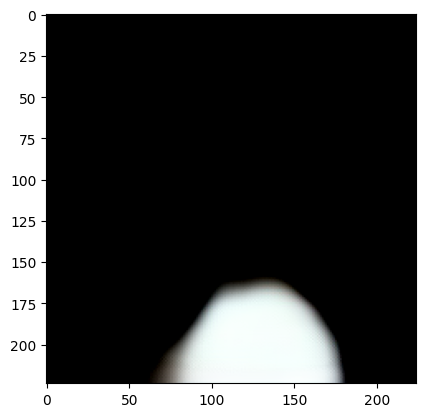

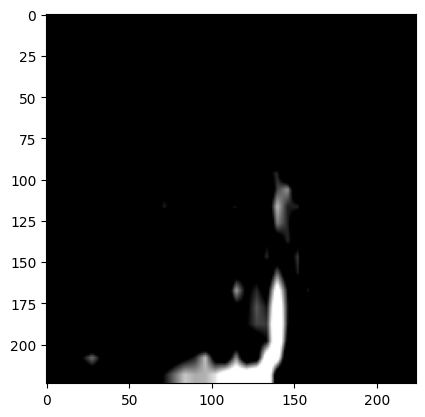

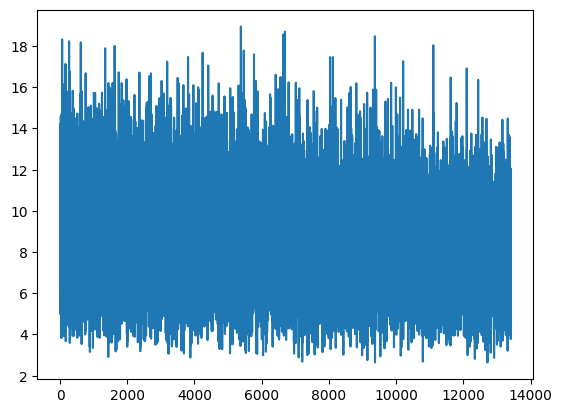

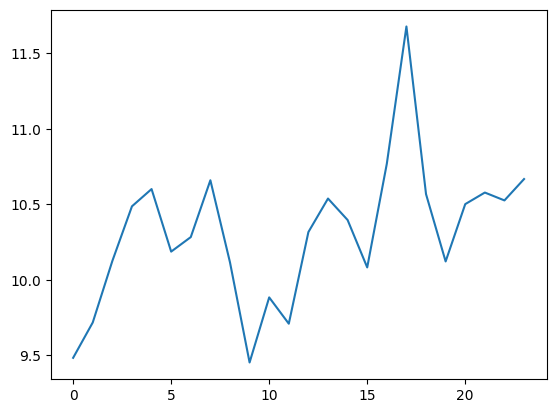

 24%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 24/100 [6:34:18<20:35:03, 975.04s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b36d7950>, test/blurry_pixcorr=0.463, test/loss=10.7, test/loss_clip_total=0.335, test/loss_prior=0.344, test/num_steps=24, test/test_bwd_pct_correct=0.879, test/test_fwd_pct_correct=0.883, train/blurry_pixcorr=0.869, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.76, train/loss_

[E24/100 I0/559]
  Loss 10.456860542297363
[E24/100 I50/559]
  Loss 6.119931697845459
[E24/100 I100/559]
  Loss 4.8474507331848145
[E24/100 I150/559]
  Loss 3.930180549621582
[E24/100 I200/559]
  Loss 11.569756507873535
[E24/100 I250/559]
  Loss 8.285841941833496
[E24/100 I300/559]
  Loss 10.835355758666992
[E24/100 I350/559]
  Loss 5.202208518981934
[E24/100 I400/559]
  Loss 6.930398941040039
[E24/100 I450/559]
  Loss 6.293973922729492
[E24/100 I500/559]
  Loss 9.725598335266113
[E24/100 I550/559]
  Loss 5.798920154571533

---Evaluating---



 24%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 24/100 [6:50:25<20:35:03, 975.04s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34ae240750>, test/blurry_pixcorr=0.461, test/loss=10.2, test/loss_clip_total=0.342, test/loss_prior=0.328, test/num_steps=25, test/test_bwd_pct_correct=0.877, test/test_fwd_pct_correct=0.879, train/blurry_pixcorr=0.863, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.91, train/lo


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/ep24 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 24 / 100


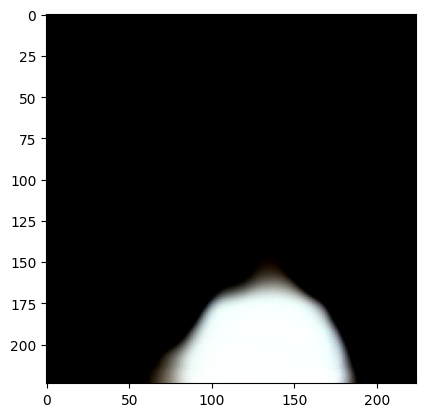

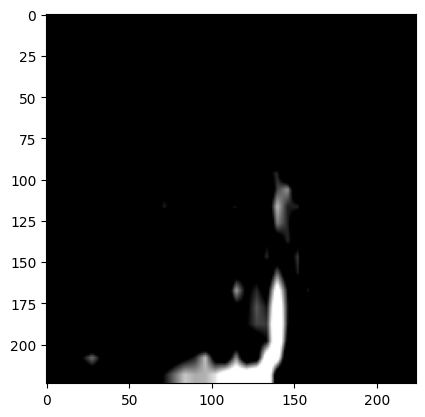

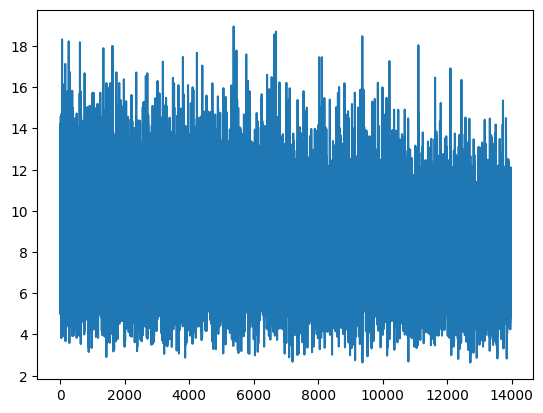

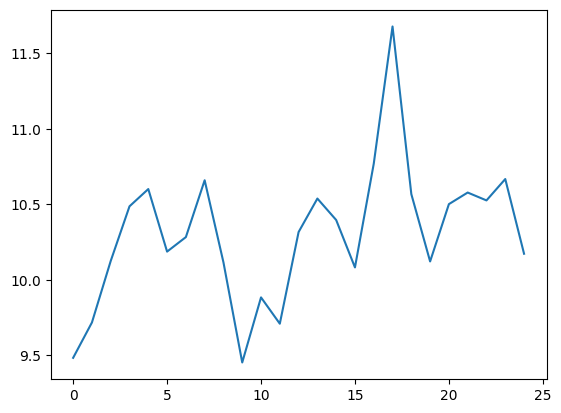

 25%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 25/100 [6:50:39<20:20:59, 976.80s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34ae240750>, test/blurry_pixcorr=0.461, test/loss=10.2, test/loss_clip_total=0.342, test/loss_prior=0.328, test/num_steps=25, test/test_bwd_pct_correct=0.877, test/test_fwd_pct_correct=0.879, train/blurry_pixcorr=0.863, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.91, train/lo

[E25/100 I0/559]
  Loss 9.919988632202148
[E25/100 I50/559]
  Loss 10.44056224822998
[E25/100 I100/559]
  Loss 10.512176513671875
[E25/100 I150/559]
  Loss 9.784367561340332
[E25/100 I200/559]
  Loss 8.505802154541016
[E25/100 I250/559]
  Loss 6.351118564605713
[E25/100 I300/559]
  Loss 5.813157558441162
[E25/100 I350/559]
  Loss 6.890189170837402
[E25/100 I400/559]
  Loss 7.315555572509766
[E25/100 I450/559]
  Loss 10.694645881652832
[E25/100 I500/559]
  Loss 12.397611618041992
[E25/100 I550/559]
  Loss 9.510576248168945

---Evaluating---



 25%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 25/100 [7:06:44<20:20:59, 976.80s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b37d78d0>, test/blurry_pixcorr=0.459, test/loss=10.4, test/loss_clip_total=0.319, test/loss_prior=0.337, test/num_steps=26, test/test_bwd_pct_correct=0.888, test/test_fwd_pct_correct=0.89, train/blurry_pixcorr=0.868, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.76, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 25 / 100


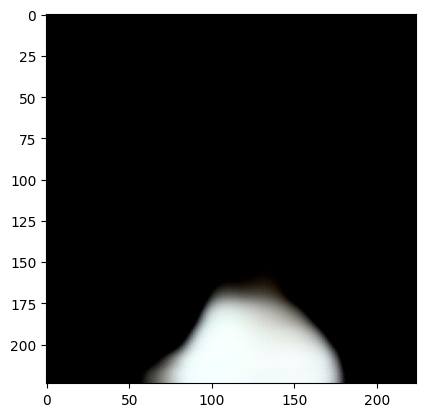

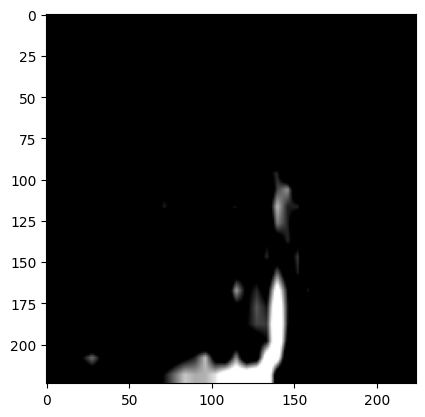

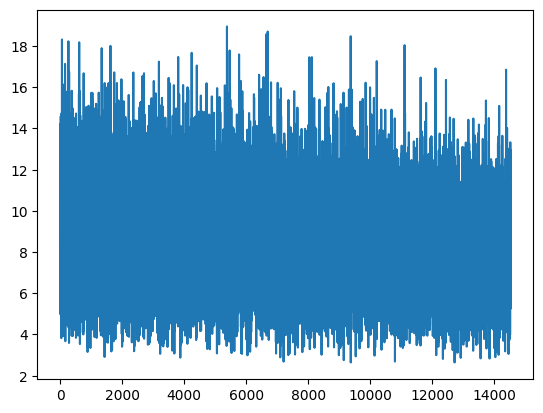

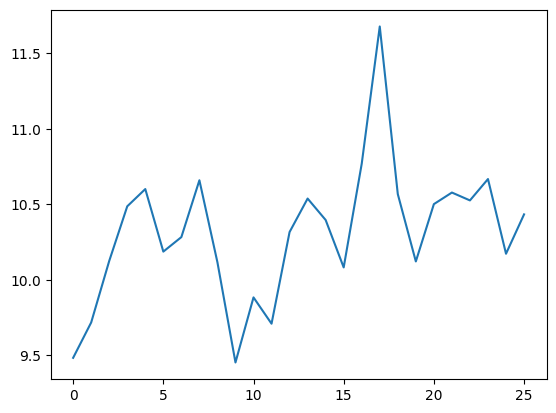

 26%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 26/100 [7:06:52<20:03:14, 975.61s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b37d78d0>, test/blurry_pixcorr=0.459, test/loss=10.4, test/loss_clip_total=0.319, test/loss_prior=0.337, test/num_steps=26, test/test_bwd_pct_correct=0.888, test/test_fwd_pct_correct=0.89, train/blurry_pixcorr=0.868, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.76, train/loss_

[E26/100 I0/559]
  Loss 10.815399169921875
[E26/100 I50/559]
  Loss 6.593626499176025
[E26/100 I100/559]
  Loss 7.571176528930664
[E26/100 I150/559]
  Loss 5.615921974182129
[E26/100 I200/559]
  Loss 4.827494144439697
[E26/100 I250/559]
  Loss 9.190569877624512
[E26/100 I300/559]
  Loss 6.214158058166504
[E26/100 I350/559]
  Loss 4.658168792724609
[E26/100 I400/559]
  Loss 5.751403331756592
[E26/100 I450/559]
  Loss 8.4938325881958
[E26/100 I500/559]
  Loss 5.518784046173096
[E26/100 I550/559]
  Loss 9.233293533325195

---Evaluating---



 26%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 26/100 [7:22:58<20:03:14, 975.61s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b2101710>, test/blurry_pixcorr=0.464, test/loss=11, test/loss_clip_total=0.345, test/loss_prior=0.355, test/num_steps=27, test/test_bwd_pct_correct=0.877, test/test_fwd_pct_correct=0.881, train/blurry_pixcorr=0.866, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.57, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 26 / 100


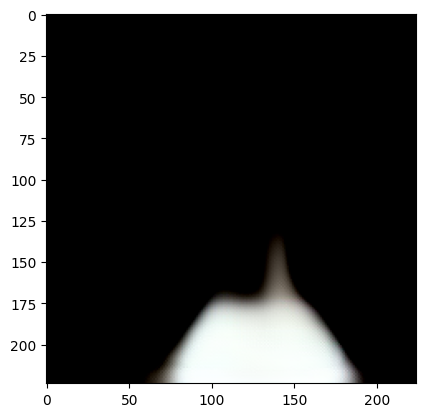

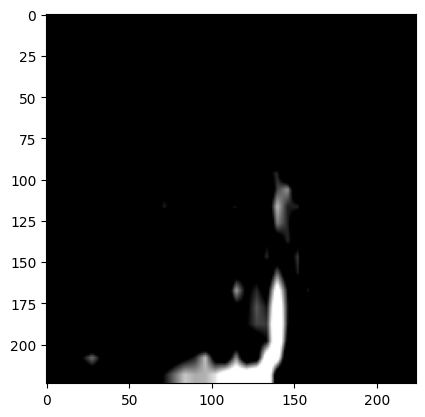

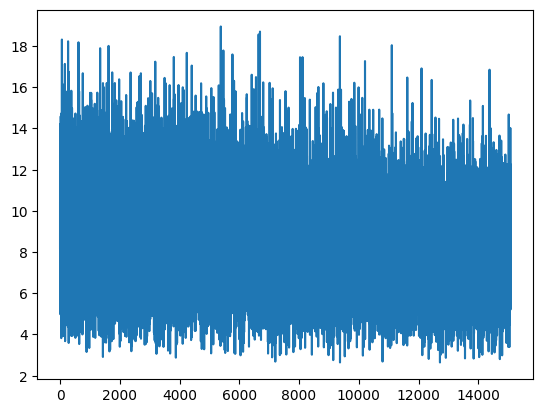

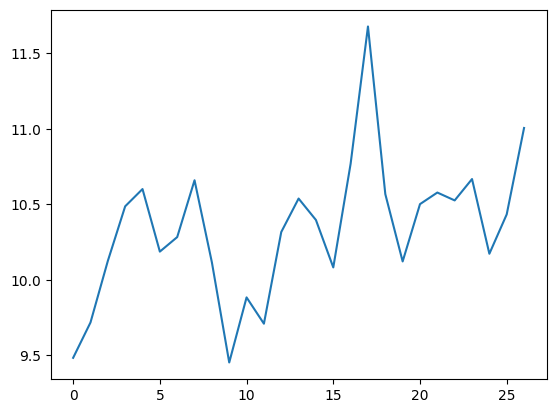

 27%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 27/100 [7:23:05<19:46:09, 974.92s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b2101710>, test/blurry_pixcorr=0.464, test/loss=11, test/loss_clip_total=0.345, test/loss_prior=0.355, test/num_steps=27, test/test_bwd_pct_correct=0.877, test/test_fwd_pct_correct=0.881, train/blurry_pixcorr=0.866, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.57, train/loss_

[E27/100 I0/559]
  Loss 11.398635864257812
[E27/100 I50/559]
  Loss 6.753002643585205
[E27/100 I100/559]
  Loss 5.635863304138184
[E27/100 I150/559]
  Loss 5.238259792327881
[E27/100 I200/559]
  Loss 7.3567795753479
[E27/100 I250/559]
  Loss 7.668133735656738
[E27/100 I300/559]
  Loss 6.870818138122559
[E27/100 I350/559]
  Loss 7.448487758636475
[E27/100 I400/559]
  Loss 8.357461929321289
[E27/100 I450/559]
  Loss 10.053454399108887
[E27/100 I500/559]
  Loss 8.133468627929688
[E27/100 I550/559]
  Loss 5.657542705535889

---Evaluating---



 27%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 27/100 [7:39:10<19:46:09, 974.92s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34ae2b8910>, test/blurry_pixcorr=0.461, test/loss=9.99, test/loss_clip_total=0.338, test/loss_prior=0.322, test/num_steps=28, test/test_bwd_pct_correct=0.89, test/test_fwd_pct_correct=0.906, train/blurry_pixcorr=0.869, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.55, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 27 / 100


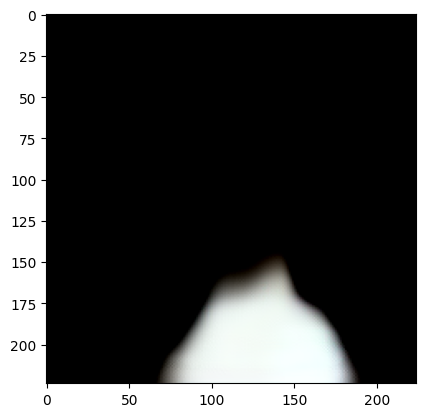

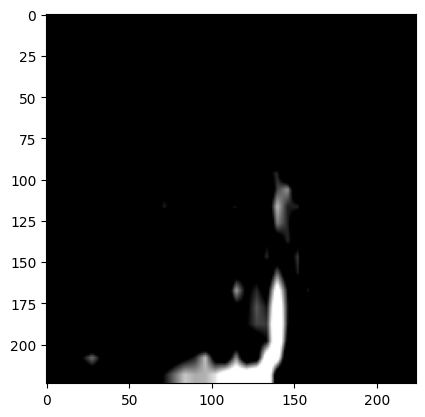

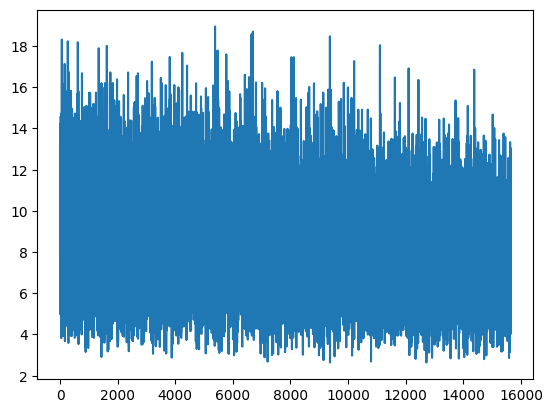

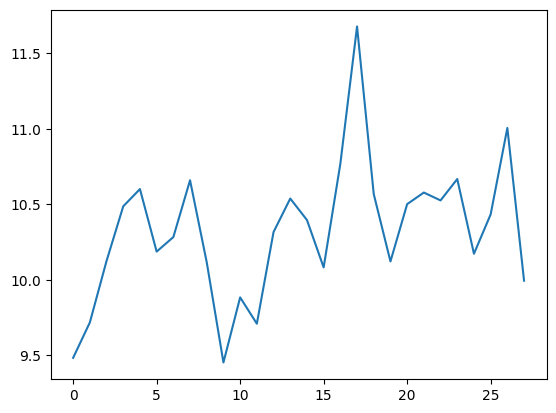

 28%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                           | 28/100 [7:39:17<19:28:57, 974.13s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34ae2b8910>, test/blurry_pixcorr=0.461, test/loss=9.99, test/loss_clip_total=0.338, test/loss_prior=0.322, test/num_steps=28, test/test_bwd_pct_correct=0.89, test/test_fwd_pct_correct=0.906, train/blurry_pixcorr=0.869, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.55, train/loss_

[E28/100 I0/559]
  Loss 6.9893574714660645
[E28/100 I50/559]
  Loss 6.835273742675781
[E28/100 I100/559]
  Loss 8.002663612365723
[E28/100 I150/559]
  Loss 4.193225860595703
[E28/100 I200/559]
  Loss 7.789901256561279
[E28/100 I250/559]
  Loss 7.19875431060791
[E28/100 I300/559]
  Loss 5.745713233947754
[E28/100 I350/559]
  Loss 7.303011894226074
[E28/100 I400/559]
  Loss 9.776803016662598
[E28/100 I450/559]
  Loss 4.779077053070068
[E28/100 I500/559]
  Loss 12.812530517578125
[E28/100 I550/559]
  Loss 9.116193771362305

---Evaluating---



 28%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                          | 28/100 [7:55:23<19:28:57, 974.13s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b37d7c50>, test/blurry_pixcorr=0.464, test/loss=10.7, test/loss_clip_total=0.333, test/loss_prior=0.345, test/num_steps=29, test/test_bwd_pct_correct=0.888, test/test_fwd_pct_correct=0.906, train/blurry_pixcorr=0.873, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.74, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 28 / 100


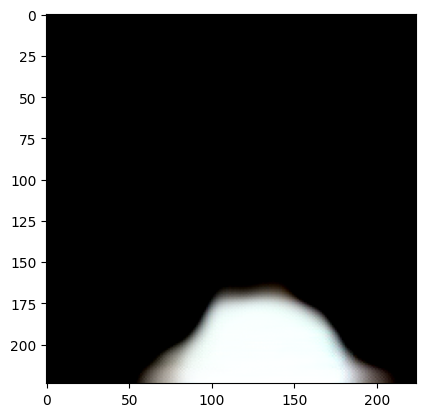

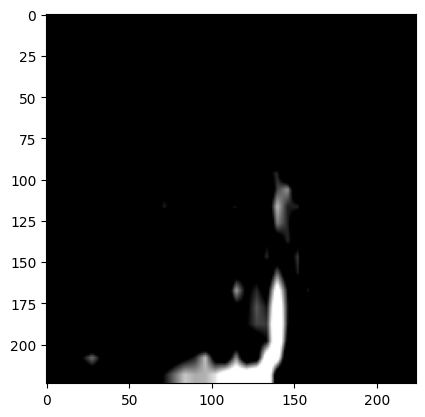

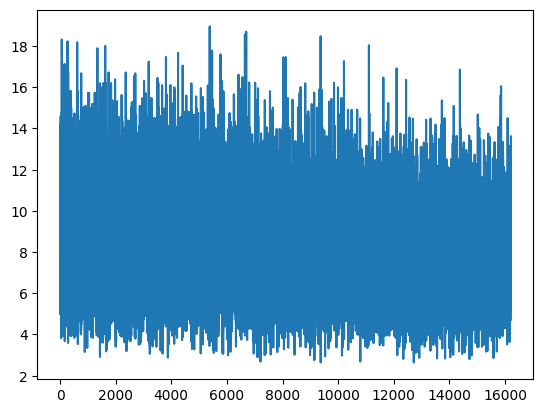

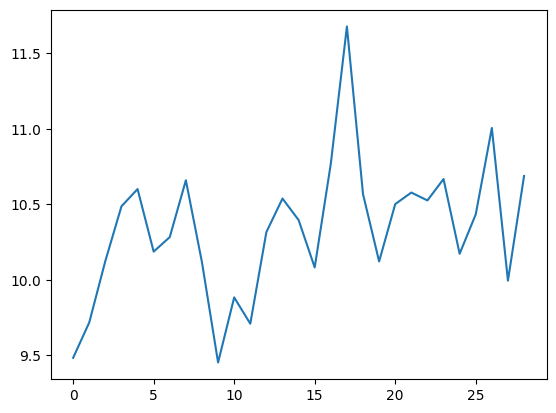

 29%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                    | 29/100 [7:55:31<19:12:21, 973.83s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b37d7c50>, test/blurry_pixcorr=0.464, test/loss=10.7, test/loss_clip_total=0.333, test/loss_prior=0.345, test/num_steps=29, test/test_bwd_pct_correct=0.888, test/test_fwd_pct_correct=0.906, train/blurry_pixcorr=0.873, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.74, train/loss_

[E29/100 I0/559]
  Loss 10.269450187683105
[E29/100 I50/559]
  Loss 8.64903450012207
[E29/100 I100/559]
  Loss 7.905407428741455
[E29/100 I150/559]
  Loss 5.128133773803711
[E29/100 I200/559]
  Loss 5.841326713562012
[E29/100 I250/559]
  Loss 6.719274997711182
[E29/100 I300/559]
  Loss 7.857802391052246
[E29/100 I350/559]
  Loss 3.667081356048584
[E29/100 I400/559]
  Loss 7.944759368896484
[E29/100 I450/559]
  Loss 8.959833145141602
[E29/100 I500/559]
  Loss 9.723995208740234
[E29/100 I550/559]
  Loss 6.359533786773682

---Evaluating---



 29%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                    | 29/100 [8:11:34<19:12:21, 973.83s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34aedc49d0>, test/blurry_pixcorr=0.461, test/loss=10.7, test/loss_clip_total=0.386, test/loss_prior=0.343, test/num_steps=30, test/test_bwd_pct_correct=0.875, test/test_fwd_pct_correct=0.858, train/blurry_pixcorr=0.871, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.58, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/ep29 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 29 / 100


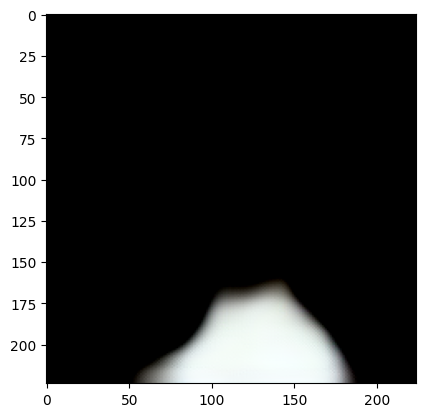

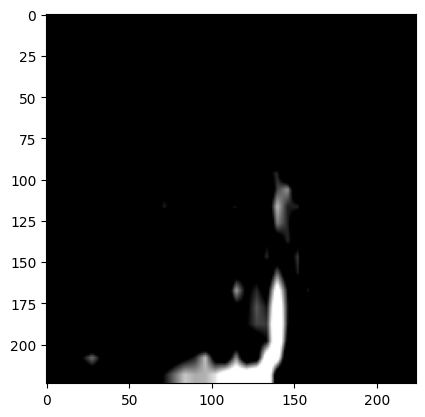

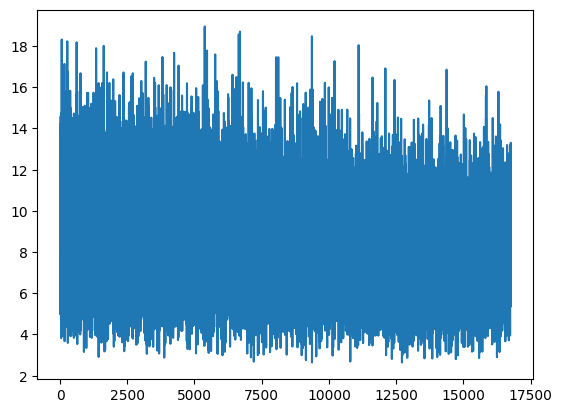

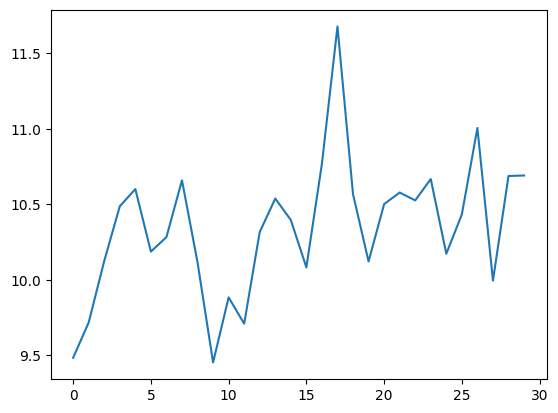

 30%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                              | 30/100 [8:11:49<18:57:42, 975.17s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34aedc49d0>, test/blurry_pixcorr=0.461, test/loss=10.7, test/loss_clip_total=0.386, test/loss_prior=0.343, test/num_steps=30, test/test_bwd_pct_correct=0.875, test/test_fwd_pct_correct=0.858, train/blurry_pixcorr=0.871, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.58, train/loss_

[E30/100 I0/559]
  Loss 3.194645643234253
[E30/100 I50/559]
  Loss 4.596477031707764
[E30/100 I100/559]
  Loss 9.705605506896973
[E30/100 I150/559]
  Loss 7.338615417480469
[E30/100 I200/559]
  Loss 8.336395263671875
[E30/100 I250/559]
  Loss 5.87497615814209
[E30/100 I300/559]
  Loss 7.225695610046387
[E30/100 I350/559]
  Loss 7.648505210876465
[E30/100 I400/559]
  Loss 6.888209342956543
[E30/100 I450/559]
  Loss 7.826382160186768
[E30/100 I500/559]
  Loss 5.765193939208984
[E30/100 I550/559]
  Loss 6.948744297027588

---Evaluating---



 30%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                               | 30/100 [8:27:58<18:57:42, 975.17s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34aeedf010>, test/blurry_pixcorr=0.46, test/loss=9.79, test/loss_clip_total=0.366, test/loss_prior=0.314, test/num_steps=31, test/test_bwd_pct_correct=0.888, test/test_fwd_pct_correct=0.862, train/blurry_pixcorr=0.871, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.26, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 30 / 100


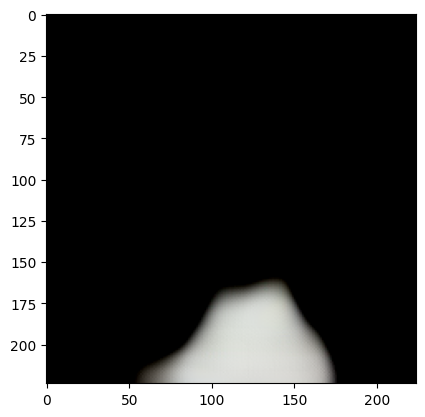

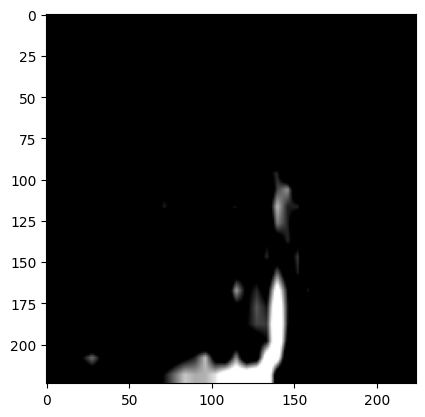

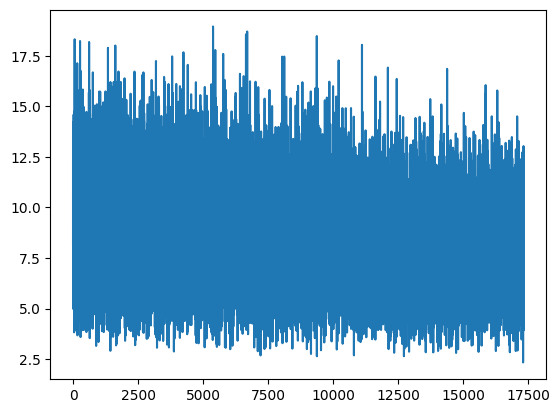

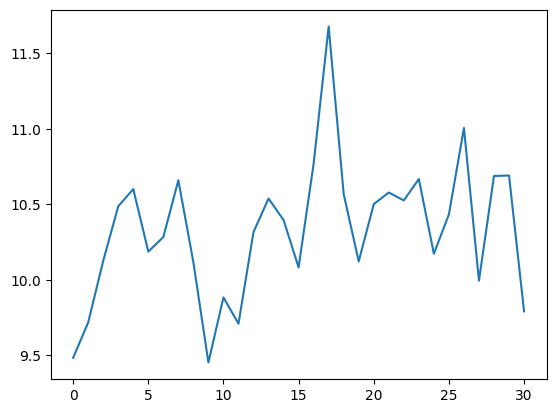

 31%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                         | 31/100 [8:28:05<18:41:43, 975.41s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34aeedf010>, test/blurry_pixcorr=0.46, test/loss=9.79, test/loss_clip_total=0.366, test/loss_prior=0.314, test/num_steps=31, test/test_bwd_pct_correct=0.888, test/test_fwd_pct_correct=0.862, train/blurry_pixcorr=0.871, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.26, train/loss

[E31/100 I0/559]
  Loss 7.347871780395508
[E31/100 I50/559]
  Loss 10.046603202819824
[E31/100 I100/559]
  Loss 7.642722129821777
[E31/100 I150/559]
  Loss 5.241685390472412
[E31/100 I200/559]
  Loss 7.524784564971924
[E31/100 I250/559]
  Loss 10.934374809265137
[E31/100 I300/559]
  Loss 3.4753661155700684
[E31/100 I350/559]
  Loss 7.389464378356934
[E31/100 I400/559]
  Loss 10.603067398071289
[E31/100 I450/559]
  Loss 6.3718485832214355
[E31/100 I500/559]
  Loss 4.49843168258667
[E31/100 I550/559]
  Loss 6.21334981918335

---Evaluating---



 31%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                           | 31/100 [8:44:14<18:41:43, 975.41s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b36fa3d0>, test/blurry_pixcorr=0.461, test/loss=11, test/loss_clip_total=0.344, test/loss_prior=0.355, test/num_steps=32, test/test_bwd_pct_correct=0.887, test/test_fwd_pct_correct=0.869, train/blurry_pixcorr=0.877, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.61, train/los


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 31 / 100


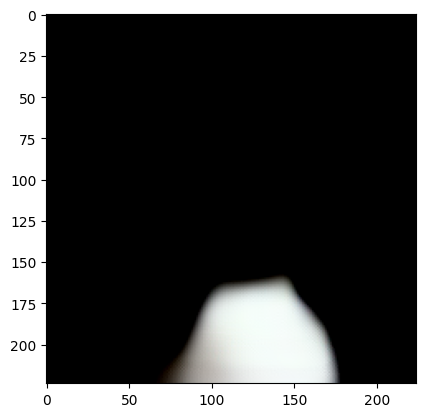

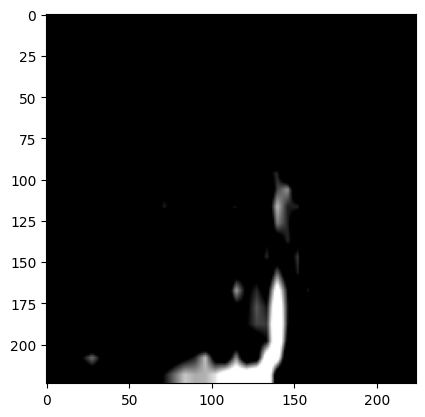

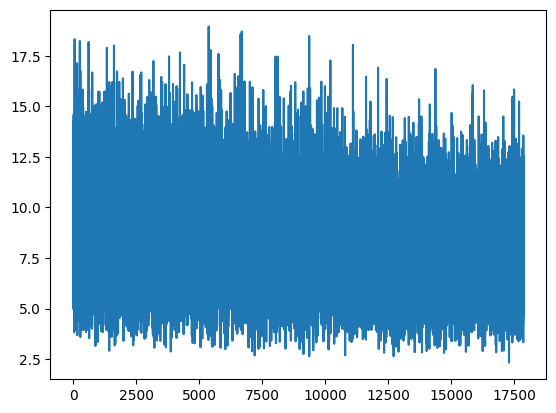

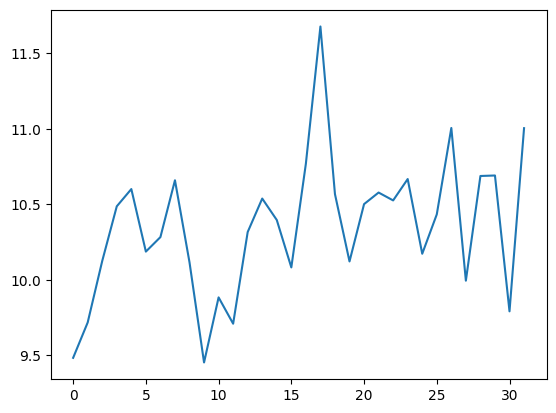

 32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                     | 32/100 [8:44:21<18:25:50, 975.74s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b36fa3d0>, test/blurry_pixcorr=0.461, test/loss=11, test/loss_clip_total=0.344, test/loss_prior=0.355, test/num_steps=32, test/test_bwd_pct_correct=0.887, test/test_fwd_pct_correct=0.869, train/blurry_pixcorr=0.877, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.61, train/los

[E32/100 I0/559]
  Loss 8.343746185302734
[E32/100 I50/559]
  Loss 5.799100875854492
[E32/100 I100/559]
  Loss 6.305494785308838
[E32/100 I150/559]
  Loss 9.495379447937012
[E32/100 I200/559]
  Loss 11.163961410522461
[E32/100 I250/559]
  Loss 12.981812477111816
[E32/100 I300/559]
  Loss 8.008865356445312
[E32/100 I350/559]
  Loss 6.4046502113342285
[E32/100 I400/559]
  Loss 8.309666633605957
[E32/100 I450/559]
  Loss 6.524485111236572
[E32/100 I500/559]
  Loss 5.161609649658203
[E32/100 I550/559]
  Loss 10.614176750183105

---Evaluating---



 32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                  | 32/100 [9:00:32<18:25:50, 975.74s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b35aeb10>, test/blurry_pixcorr=0.459, test/loss=10.7, test/loss_clip_total=0.351, test/loss_prior=0.346, test/num_steps=33, test/test_bwd_pct_correct=0.885, test/test_fwd_pct_correct=0.887, train/blurry_pixcorr=0.878, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.46, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__03-04-25_16-06/last ckpt!---

Finished epoch 32 / 100


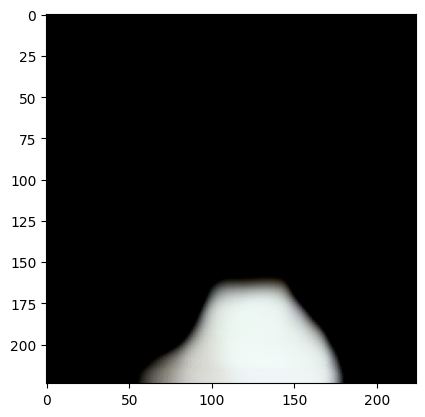

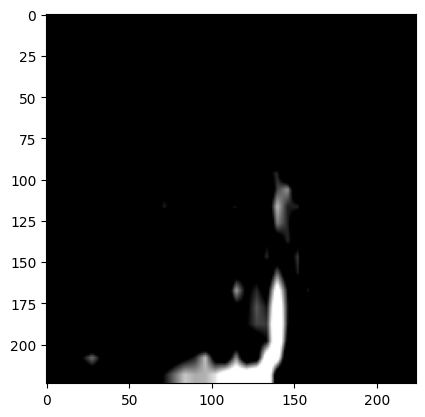

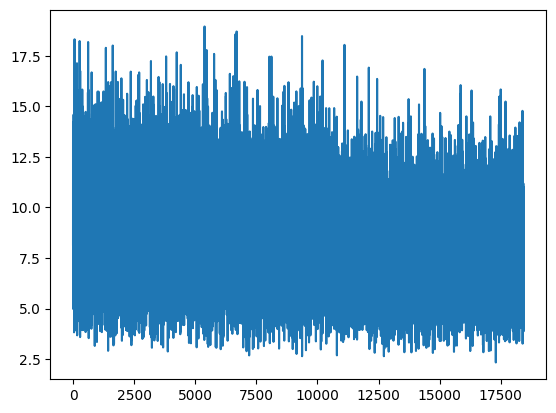

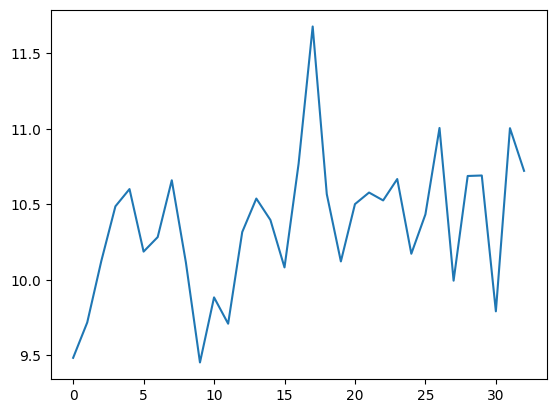

 33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                            | 33/100 [9:00:39<18:10:11, 976.29s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b35aeb10>, test/blurry_pixcorr=0.459, test/loss=10.7, test/loss_clip_total=0.351, test/loss_prior=0.346, test/num_steps=33, test/test_bwd_pct_correct=0.885, test/test_fwd_pct_correct=0.887, train/blurry_pixcorr=0.878, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.46, train/loss_

[E33/100 I0/559]
  Loss 5.9370222091674805
[E33/100 I50/559]
  Loss 5.136098861694336
[E33/100 I100/559]
  Loss 5.32243537902832
[E33/100 I150/559]
  Loss 8.838401794433594
[E33/100 I200/559]
  Loss 10.011662483215332
[E33/100 I250/559]
  Loss 11.782401084899902
[E33/100 I300/559]
  Loss 8.546451568603516
[E33/100 I350/559]
  Loss 5.791879653930664
[E33/100 I400/559]
  Loss 6.923006534576416
[E33/100 I450/559]
  Loss 6.733672618865967
[E33/100 I500/559]
  Loss 8.09823226928711


 33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                            | 33/100 [9:14:04<18:44:56, 1007.40s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f34b35aeb10>, test/blurry_pixcorr=0.459, test/loss=10.7, test/loss_clip_total=0.351, test/loss_prior=0.346, test/num_steps=33, test/test_bwd_pct_correct=0.885, test/test_fwd_pct_correct=0.887, train/blurry_pixcorr=0.878, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.46, train/loss_

KeyboardInterrupt: 

In [16]:
### tracking
epoch = 0
losses, test_losses, lrs = [], [], []
best = {"loss": 1e9, "epoch": 0}
torch.cuda.empty_cache()

### optimization
mse = nn.MSELoss()
l1 = nn.L1Loss()
cfg["model"]["cos_anneal_start"] = 0.004
cfg["model"]["cos_anneal_end"] = 0.0075
soft_loss_temps = utils.cosine_anneal(
    cfg["model"]["cos_anneal_start"],
    cfg["model"]["cos_anneal_end"],
    cfg["model"]["num_epochs"] - int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"])
)

### run
model.to(cfg["device"])
progress_bar = tqdm(range(epoch, cfg["model"]["num_epochs"]), ncols=1200, disable=False)
seed_all(cfg["seed"])
for epoch in progress_bar:
    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    recon_cossim = 0.
    recon_mse = 0.
    loss_clip_total = 0.
    loss_blurry_total = 0.
    loss_blurry_cont_total = 0.
    loss_prior_total = 0.
    blurry_pixcorr = 0.

    train_dl = get_dataloaders(config=cfg)[0]["train"][cfg["data_name"]]

    ### train
    model.train()
    for train_i, batch in enumerate(train_dl):
        if train_i % 50 == 0:
            print(f"[E{epoch}/{cfg['model']['num_epochs']} I{train_i}/{cfg['model']['num_iterations_per_epoch']}]")
        with torch.cuda.amp.autocast(dtype=cfg["data_type"]):
            optimizer.zero_grad()
            loss = 0.

            ### select data
            voxel_list = [dp["resp"].unsqueeze(1).to(cfg["device"]) for dp in batch]  # (B, 1, num_voxels = num_of_neurons)
            image = img_tform(torch.cat([dp["stim"] for dp in batch], dim=0).to(cfg["device"]))  # (B, 3, 224, 224)

            ### augment image
            if cfg["model"]["use_image_aug"]: 
                image = img_augment(image)

            if epoch < int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"]):
                perm_list = [perm_iters[f"subj0{s}_iter{train_i}"].detach().to(cfg["device"]) for s in cfg["model"]["subj_list"]]
                perm = torch.cat(perm_list, dim=0)
                betas_list = [betas_iters[f"subj0{s}_iter{train_i}"].detach().to(cfg["device"]) for s in cfg["model"]["subj_list"]]
                betas = torch.cat(betas_list, dim=0).to(cfg["data_type"])
                select_list = [select_iters[f"subj0{s}_iter{train_i}"].detach().to(cfg["device"]) for s in cfg["model"]["subj_list"]]
                select = torch.cat(select_list, dim=0)

            ### map voxels to clip space
            voxel_ridge = torch.cat([model.ridge(voxel_list[si], si) for si, s in enumerate(cfg["model"]["subj_list"])], dim=0)
            backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

            ### map GT image to clip space
            clip_target = clip_img_embedder(image)
            assert not torch.any(torch.isnan(clip_target))

            ### normalize clip embeddings
            if cfg["model"]["clip_scale"] > 0:
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

            if cfg["model"]["use_prior"]:
                loss_prior, prior_out = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                if torch.isnan(loss_prior).any():
                    print(f"  Loss prior is NaN, skipping...")
                    del backbone, clip_voxels, blurry_image_enc_, clip_target, clip_voxels_norm, clip_target_norm, loss_prior, prior_out
                    import gc
                    gc.collect()
                    torch.cuda.empty_cache()
                    continue
                for i in range(3):
                    if torch.isnan(loss_prior).any():
                        print(f"  Loss prior is NaN, trying again...")
                        del loss_prior, prior_out
                        torch.cuda.empty_cache()
                        loss_prior, prior_out = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                    else:
                        break

                loss_prior_total += loss_prior.item()
                loss_prior *= cfg["model"]["prior_scale"]
                loss += loss_prior

                recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target).mean().item()
                recon_mse += mse(prior_out, clip_target).item()

            if cfg["model"]["clip_scale"] > 0:
                if epoch < int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"]):
                    loss_clip = utils.mixco_nce(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006,
                        perm=perm, betas=betas, select=select)
                else:
                    epoch_temp = soft_loss_temps[epoch - int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"])]
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=epoch_temp,
                    )

                loss_clip_total += loss_clip.item()
                loss_clip *= cfg["model"]["clip_scale"]
                loss += loss_clip

            if cfg["model"]["blurry_recon"]:     
                image_enc_pred, transformer_feats = blurry_image_enc_

                # image_enc = autoenc.encode(2 * image - 1).latent_dist.mode() * 0.18215
                image_enc = autoenc.encode(image).latent_dist.mode() * 0.18215  # already z-scored
                loss_blurry = l1(image_enc_pred, image_enc)
                loss_blurry_total += loss_blurry.item()

                if epoch < int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"]):
                    image_enc_shuf = image_enc[perm]
                    betas_shape = [-1] + [1]*(len(image_enc.shape)-1)
                    image_enc[select] = image_enc[select] * betas[select].reshape(*betas_shape) + \
                        image_enc_shuf[select] * (1 - betas[select]).reshape(*betas_shape)

                # image_norm = (image - mean) / std
                image_norm = image  # already z-scored
                # print(f"  Blurring Aug {image_norm.shape}")
                # image_aug = (blur_augs(image) - mean) / std
                image_aug = blur_augs(image)  # already z-scored
                _, cnx_embeds = cnx(image_norm)
                _, cnx_aug_embeds = cnx(image_aug)

                cont_loss = utils.soft_cont_loss(
                    nn.functional.normalize(transformer_feats.reshape(-1, transformer_feats.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_aug_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    temp=0.2)
                loss_blurry_cont_total += cont_loss.item()

                loss += (loss_blurry + 0.1 * cont_loss) * cfg["model"]["blur_scale"] #/.18215

            if cfg["model"]["clip_scale"]>0:
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

            if cfg["model"]["blurry_recon"]:
                with torch.no_grad():
                    # only doing pixcorr eval on a subset of the samples per batch because its costly & slow to compute autoenc.decode()
                    random_samps = np.random.choice(np.arange(len(image)), size=max(len(image)//5, 1), replace=False)
                    # blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample / 2 + 0.5).clamp(0,1)
                    blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample)
                    pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    blurry_pixcorr += pixcorr.item()

            if train_i % 50 == 0:
                print(f"  Loss {loss.item()}")
            utils.check_loss(loss)
            # accelerator.backward(loss)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])

            if cfg["model"]["optimization"]["lr_scheduler_type"] is not None:
                lr_scheduler.step()

            optimizer.zero_grad()
            torch.cuda.empty_cache()

    ### evaluate
    print("\n---Evaluating---\n")
    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=cfg["data_type"]):
        n_minibatches = 0
        test_loss=0.
        test_loss_clip_total = 0.
        test_loss_prior_total = 0.
        test_blurry_pixcorr = 0.
        test_fwd_percent_correct = 0.
        test_bwd_percent_correct = 0.
        eval_dl = get_dataloaders(config=cfg)[0]["val"][cfg["data_name"]]
        for batch in eval_dl:
            voxel_list = [dp["resp"].unsqueeze(1).to(cfg["device"]) for dp in batch]  # (B, 1, num_voxels = num_of_neurons)
            image = img_tform(torch.cat([dp["stim"] for dp in batch], dim=0).to(cfg["device"]))  # (B, 3, 224, 224)

            voxel_ridge = torch.cat([model.ridge(voxel_list[si], si) for si, s in enumerate(cfg["model"]["subj_list"])], dim=0)
            backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

            clip_target = clip_img_embedder(image.float())
            if cfg["model"]["clip_scale"]>0:
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

            if cfg["model"]["use_prior"]:
                loss_prior, _ = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                test_loss_prior_total += loss_prior.item()
                loss_prior *= cfg["model"]["prior_scale"]
                test_loss += loss_prior

            if cfg["model"]["clip_scale"]>0:
                loss_clip = utils.soft_clip_loss(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=.006,
                )

                test_loss_clip_total += loss_clip.item()
                loss_clip = loss_clip * cfg["model"]["clip_scale"]
                test_loss += loss_clip

            if cfg["model"]["blurry_recon"]:
                image_enc_pred, _ = blurry_image_enc_
                # blurry_recon_images = (autoenc.decode(image_enc_pred/0.18215).sample / 2 + 0.5).clamp(0,1)
                blurry_recon_images = (autoenc.decode(image_enc_pred/0.18215).sample)
                pixcorr = utils.pixcorr(image, blurry_recon_images)
                test_blurry_pixcorr += pixcorr.item()

            if cfg["model"]["clip_scale"]>0:
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                test_fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                test_bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

            n_minibatches += 1

        test_loss /= n_minibatches
        test_loss_clip_total /= n_minibatches
        test_loss_prior_total /= n_minibatches
        test_blurry_pixcorr /= n_minibatches
        test_fwd_percent_correct /= n_minibatches
        test_bwd_percent_correct /= n_minibatches

        utils.check_loss(test_loss)                
        test_losses.append(test_loss.item())

        if test_loss.item() < best["loss"]:
            save_ckpt(f'best')
            best["loss"] = test_loss.item()
            best["epoch"] = epoch

        logs = {
            "train/loss": np.mean(losses[-(train_i+1):]),
            "test/loss": test_loss.item(),
            "train/lr": lrs[-1],
            "train/num_steps": len(losses),
            "test/num_steps": len(test_losses),
            "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
            "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
            "test/test_fwd_pct_correct": test_fwd_percent_correct,
            "test/test_bwd_pct_correct": test_bwd_percent_correct,
            "train/loss_clip_total": loss_clip_total / (train_i + 1),
            "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
            "train/loss_blurry_cont_total": loss_blurry_cont_total / (train_i + 1),
            "test/loss_clip_total": test_loss_clip_total,
            "train/blurry_pixcorr": blurry_pixcorr / (train_i + 1),
            "test/blurry_pixcorr": test_blurry_pixcorr,
            "train/recon_cossim": recon_cossim / (train_i + 1),
            "train/recon_mse": recon_mse / (train_i + 1),
            "train/loss_prior": loss_prior_total / (train_i + 1),
            "test/loss_prior": test_loss_prior_total,
        }

        # if finished training, save jpg recons if they exist
        if (epoch == cfg["model"]["num_epochs"]-1) or (epoch % cfg["model"]["ckpt_interval"] == 0):
            if cfg["model"]["blurry_recon"]:    
                # image_enc = autoenc.encode(2*image[:4]-1).latent_dist.mode() * 0.18215
                image_enc = autoenc.encode(image[:4]).latent_dist.mode() * 0.18215  # already z-scored
                # transform blurry recon latents to images and plot it
                fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                jj=-1
                for j in [0,1,2,3]:
                    jj+=1
                    # axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    axes[jj].imshow(utils.torch_to_Image(autoenc.decode(image_enc[[j]]/0.18215).sample))
                    axes[jj].axis('off')
                    jj+=1
                    # axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc_pred[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    axes[jj].imshow(utils.torch_to_Image(autoenc.decode(image_enc_pred[[j]]/0.18215).sample))
                    axes[jj].axis('off')

                if wandb_log:
                    logs[f"test/blur_recons"] = wandb.Image(fig, caption=f"epoch{epoch:03d}")
                    plt.close()
                else:
                    plt.show()

        progress_bar.set_postfix(**logs)

        if wandb_log: wandb.log(logs)

    # Save model checkpoint and reconstruct
    # if (ckpt_saving) and (epoch % ckpt_interval == 0):
    if (epoch + 1) % 5 == 0:
        save_ckpt(f'ep{epoch}')
    save_ckpt(f'last')

    # wait for other GPUs to catch up if needed
    # accelerator.wait_for_everyone()
    torch.cuda.empty_cache()
    print(f"Finished epoch {epoch} / {cfg['model']['num_epochs']}")
    
    plt.imshow(blurry_recon_images[0].permute(1,2,0).cpu().detach().to(torch.float32))
    plt.show()
    plt.imshow(image[0].permute(1,2,0).cpu().detach().to(torch.float32))
    plt.show()
    plt.plot(losses)
    plt.show()
    plt.plot(test_losses)
    plt.show()

print("\n===Finished!===\n")
save_ckpt(f'last')

In [ ]:
plt.plot(losses)
plt.show()
plt.plot(test_losses)
plt.show()